# Conteggi di Ammassi di Galassie per Euclid

## Fantin Valerio

## 1. Introduzione
Nella seguente analisi vengono considerati dati riguardanti ammassi di galassie con caratteristiche simili a quelli che saranno osservati dalla missione Euclid (ESA), l'obbiettivo è quello di studiare le distribuzioni di massa per ricavare il valore di alcuni parametri cosmologici.


L'analisi verrà effettuata confrontando la distribuzione di massa dei dati raccolti con la **Halo Mass Function** (HMF), distribuzione teorica già implementata all'interno della libreria python **Colossus**.

In [166]:
from colossus.cosmology import cosmology
from colossus.lss import mass_function

#Altre librerie utilizzate per l'implementazione
import pandas as pd
import numpy as np
import scipy
from matplotlib import pyplot as plt
import pygtc

#Inferenza sui parametri
import emcee
from scipy.optimize import minimize
from scipy.stats import norm
from scipy.special import factorial



## 2. Raccolta dati


In [191]:
#Utilizzando la libreria Pandas, i dati osservati vengono raccolti all'interno di un DataFrame
data = pd.read_csv('Euclid_ammassi.csv')
data = pd.DataFrame(data)

print("Numero dei dati raccolti : {}".format(len(data)))

data.head()

Numero dei dati raccolti : 362637


,Unnamed: 0,mass,z,vol
0,0,1.060613e+14,0.506,1.479387e+10
1,1,1.097076e+14,0.506,1.479387e+10
2,2,1.588869e+14,0.506,1.479387e+10
3,3,1.336345e+14,0.506,1.479387e+10
4,4,3.078288e+14,0.506,1.479387e+10


All'interno del Dataframe sono presenti **362637** valori suddivisi in:
- mass --> massa in  unità di massa solare $M\odot$
- z --> valore di redshift
- vol --> volume dell'Universo [$ h^{-3} Mpc^3$] 

Di seguito i valori di massa,volume e redshift vengono raccolti all'interno delle variabili **massTot**, **z** e **vol**. 

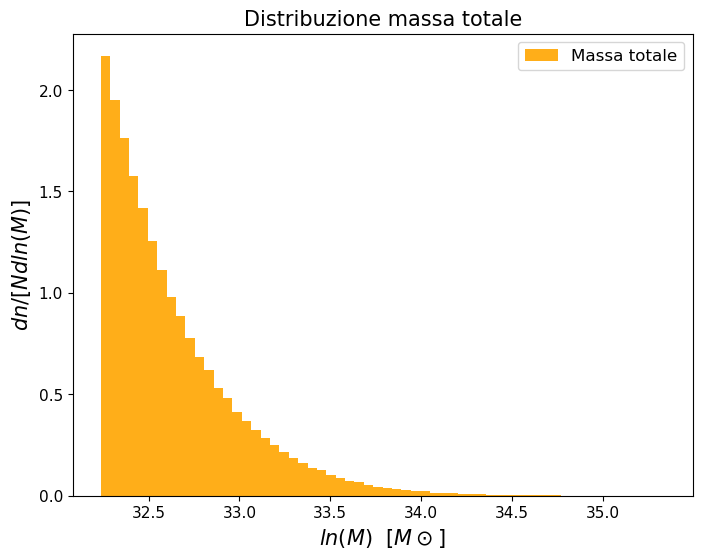

In [168]:
#raccolgo le 3 colonne
massTot = data['mass']
z = data['z']
vol = data['vol']

#istogramma della densità della distribuzione di massa
plt.figure(figsize=(8,6))
plt.title('Distribuzione massa totale',fontsize = 15)
plt.hist(np.log(massTot),density=True,bins=60,alpha = 0.9, color = 'orange',label = 'Massa totale')
plt.legend(prop={'size': 12})
plt.ylabel("$dn/[Ndln(M)]}$", fontsize=15)
plt.xlabel("$ln(M)$  [$M\odot$]", fontsize=15)
plt.tick_params(axis='x', labelsize=11)
plt.tick_params(axis='y', labelsize=11)
plt.show()

In questo primo istogramma è possibile osservare la distribuzione della massa totale espressa come densità normalizzata, ovvero $\frac{dn}{Ndln(M)}$, dove $dn$ è il numero di elementi nell'i-esio bin logaritmico, $N$ è il numero di dati totali e $dln(M)$ è l'ampiezza del bin logaritmico della massa.

Applicando delle maschere sul valore di redshift al Dataframe è possibile suddividere i dati nei 3 bin di redshift.

In [169]:
#Analisi preliminare sui valori di z
z1 = np.min(z)   #restituisce il valore z1 = 0.506 (coincide con i primi dati)
z3 = np.max(z)   #restituisce il valore z3 = 1.500 

#divido il dataframe nei 3 bin di redshift applicando le seguenti maschere 
data1 = data.loc[data['z'] == z1]
data2 = data.loc[(data['z'] != z1) & (data['z']!= z3)]      #trovo il valore z2 = 1.019
data3 = data.loc[(data['z'] == z3)]

#Osservando i dataframe estrapolo i seguenti valori di redshift

z1 = 0.506
z2 = 1.019 
z3 = 1.5

print("-------------------------")
print("Dati per {}:".format(z1))
print(data1.head())
print("-------------------------")
print("Dati in {}:".format(z2))
print(data2.head())
print("-------------------------")
print("Dati in {}:".format(z3))
print(data3.head())
print("-------------------------")

#Il valore di volume è uguale in ogni bin, quindi non mi crea problemi selezionare il massimo
vol1 = np.max(data1['vol'])
vol2 = np.max(data2['vol'])
vol3 = np.max(data3['vol'])


-------------------------
Dati per 0.506:
   Unnamed: 0          mass      z           vol
0           0  1.060613e+14  0.506  1.479387e+10
1           1  1.097076e+14  0.506  1.479387e+10
2           2  1.588869e+14  0.506  1.479387e+10
3           3  1.336345e+14  0.506  1.479387e+10
4           4  3.078288e+14  0.506  1.479387e+10
-------------------------
Dati in 1.019:
        Unnamed: 0          mass      z           vol
168897      168897  1.122773e+14  1.019  4.783826e+10
168898      168898  1.382684e+14  1.019  4.783826e+10
168899      168899  2.561905e+14  1.019  4.783826e+10
168900      168900  1.418248e+14  1.019  4.783826e+10
168901      168901  1.452855e+14  1.019  4.783826e+10
-------------------------
Dati in 1.5:
        Unnamed: 0          mass    z           vol
310904      310904  1.270383e+14  1.5  9.112247e+10
310905      310905  1.117731e+14  1.5  9.112247e+10
310906      310906  2.968534e+14  1.5  9.112247e+10
310907      310907  1.497517e+14  1.5  9.112247e+10



I dati raccolti sono divisi in questi bin di redshift e volume : 
- $z_1$ = $0.506$   $\quad$   $vol_1 \approx 1.47e+14 \quad$ [$ h^{-3} Mpc^3$]
- $z_2$ = $1.019 $ $\quad$   $vol_2 \approx 4.78e+14 \quad$  [$ h^{-3} Mpc^3$]
- $z_3$ = $1.500$   $\quad$  $vol_3\approx  9.11e+14 \quad$  [$ h^{-3} Mpc^3$]

In [171]:
#Raccolgo i valori delle masse e volumi in ogni bin di redshift
mass1 = (data1['mass'])
mass2 = (data2['mass'])
mass3 = (data3['mass'])


#Per comodità raggruppo le stesse quantità all'interno di liste e array

mass = [mass1,mass2,mass3]   #lista masse

z = np.array([z1,z2,z3])     #array redshift

N = np.array([len(mass1),len(mass2),len(mass3)])     #array del numero di dati

vol = np.array([vol1,vol2,vol3])      #array volume


#stampo il numero di elementi in ogni Dataframe
i = 0
som = 0
while i<3:
    print("-------------------------")
    print('Numero dati per z = {} : {}'.format(z[i],len(mass[i])))
    print("-------------------------")
    som = som + len(mass[i])   #Per controllare che la somma sia uguale a 362637
    i = i+1

#print(som)

-------------------------
Numero dati per z = 0.506 : 168897
-------------------------
-------------------------
Numero dati per z = 1.019 : 142007
-------------------------
-------------------------
Numero dati per z = 1.5 : 51733
-------------------------


Avendo isolato i dati nei rispettivi bin di redshift, è possibile studiare la distribuzione delle masse osservate al variare di z.

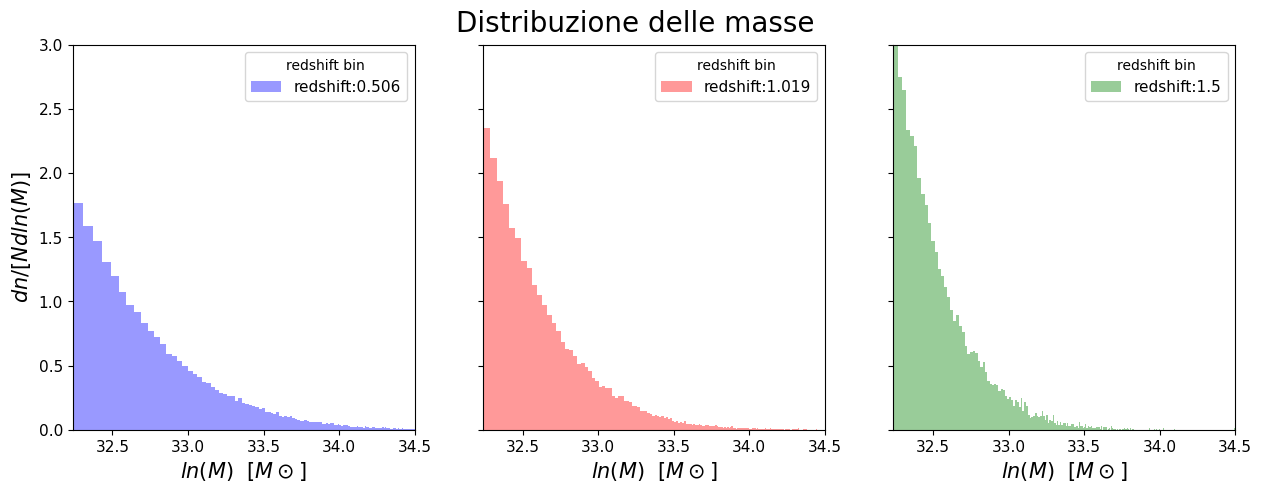

In [192]:
#decido le seguenti "spaziature", ne prendo una per bin di redshift 
xarr1 = np.linspace(np.min(mass[0]),np.max(mass[0]),300)
xarr2 = np.linspace(np.min(mass[1]),np.max(mass[1]),300)
xarr3 = np.linspace(np.min(mass[2]),np.max(mass[2]),300)

xarr = np.array([xarr1,xarr2,xarr3])
bins = np.log(xarr)        #spaziatura logaritmica
dx= bins[:,1]-bins[:,0]    #ampiezza dei bin 

#Costruisco il plot
color = ['blue','red','green']

fig, ax  = plt.subplots(1, 3,figsize=(15, 5),sharey = True)
fig.suptitle('Distribuzione delle masse',fontsize = 20, y=0.95)
i = 0
while i < 3:
    ax[i].hist(np.log(mass[i]),bins=bins[i],density =True,color=color[i],alpha=0.4,label='redshift:{}'.format(z[i]))  
    
    ax[i].legend(title = "redshift bin",prop={'size': 11})
    ax[0].set_ylabel("$dn/[Ndln(M)]}$", fontsize=15)
    ax[i].set_xlabel("$ln(M)$  [$M\odot$]", fontsize=15)
    ax[i].tick_params(axis='x', labelsize=11)
    ax[i].tick_params(axis='y', labelsize=11)
    ax[i].set_xlim([bins[i,0], 34.5])
    ax[i].set_ylim(0, 3)

    i = i+1


Dai grafici si osserva che l'andamento della distribuzione è simile per ogni redshift considerato.\
Si osserva una quantità elevata di dati nel range di ln(M) pari a [32.0 , 33.0], verso le code delle distribuzione è possibile osservare delle fluttuazioni del valore, in particolare nel grafico rappresentante z = 1.5. \
Si osserva inoltre che all'aumentare del valore di redshift e volume dell'universo le masse tendono a concentrarsi nel range [32.0 , 32.5] del ln(M) e aumentano le fluttuazioni lungo le code.

## 2. Dati Teorici


La curva teorica che descrive l'andamento delle distribuzioni delle masse degli ammassi galattici è la **Halo Mass Function** (HMF), implementata con la libreria Colossus. \
Questa funzione dipende dai parametri cosmologici H0 (costante di Hubble), Om0 (densità di materia totale), Ob0 (densità dei barioni), sigma8 (amepizza delle fluttuazioni di densità) e ns (indice spettrale delle fluttuazioni primordiali di densità); dipende anche dal valore di redshift e volume.

In [193]:
#implementazione HMF
def mfunc(m_arr,z,vol,N):
    params = {'flat': True, 'H0': 67.77, 'Om0': 0.31, 'Ob0': 0.049,'sigma8': 0.81, 'ns': 0.96}
    cosmology.addCosmology('myCosmo', params)
    cosmo = cosmology.setCosmology('myCosmo')
    function = mass_function.massFunction(m_arr, z, mdef='vir',model='despali16', q_out='dndlnM')    
    return (function*vol)/N     #ottengo dn/(N*dln(M))


Nella seguente implementazione viene calcolata la HMF.\
Dato che la funzione in output sarebbe $\frac{dn}{Vdln(M)}$, quindi numero di eventi nell'i-esimo bin per unità di volume e ampiezza logaritmica del bin, per poterla confrontare con i plot precedenti è sufficente moltiplicare per il volume e dividere per il numero di eventi totale.
$$\frac{dn}{N dln(M)}  = \frac{dn}{Vdln(M)}*\frac{V}{N} $$

Di seguito vengono confrontati i valori teorici con i valori raccolti.

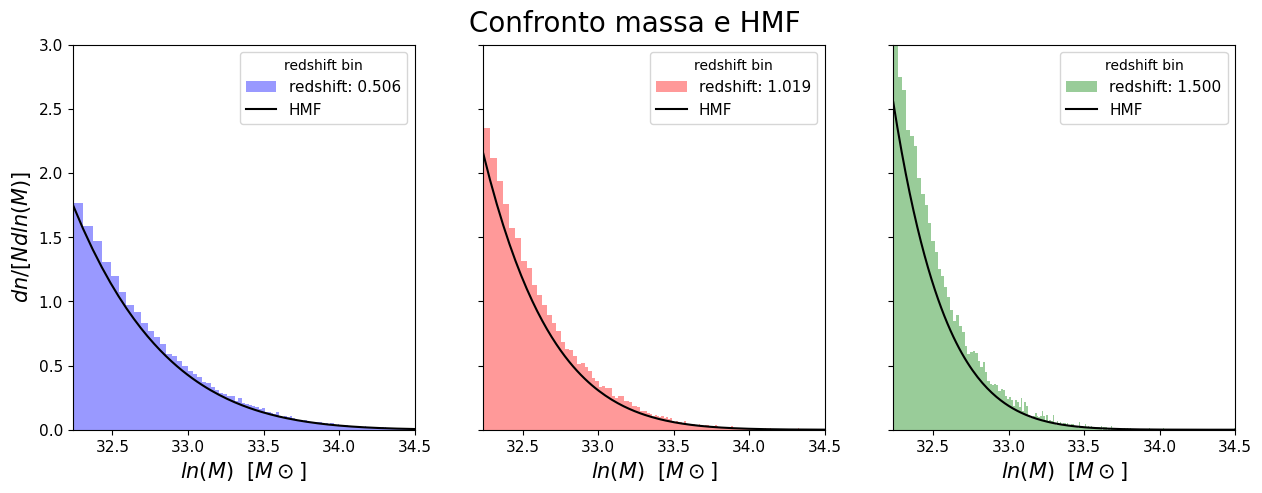

In [194]:
#mi salvo i conteggi in ogni bin dell'istogramma dei valori osservati
counts = [0,0,0]

#Costruisco il plot
color = ['blue','red','green']

fig, ax  = plt.subplots(1, 3,figsize=(15, 5),sharey = True)
fig.suptitle('Confronto massa e HMF',fontsize = 20, y=0.95)
i = 0
while i < 3:
    counts_, bin_edges_, patches = ax[i].hist(np.log(mass[i]),bins=bins[i],density =True,color=color[i],alpha=0.4,label=f'redshift: {z[i]:.3f}') 
    ax[i].plot(bins[i], mfunc(xarr[i],z[i],vol[i],N[i]),color='black',label = 'HMF')
   
    ax[i].legend(title = "redshift bin",prop={'size': 11})
    ax[0].set_ylabel("$dn/[Ndln(M)]}$", fontsize=15)
    ax[i].set_xlabel("$ln(M)$  [$M\odot$]", fontsize=15)
    ax[i].tick_params(axis='x', labelsize=11)
    ax[i].tick_params(axis='y', labelsize=11)
    ax[i].set_xlim([bins[i,0], 34.5]) 
    ax[i].set_ylim(0, 3)
    counts[i] = counts_        #qui salvo i conteggi della distribuzione osservata (dn/Ndln(M))
    i = i+1



La curva teorica segue l'andamento dei dati raccolti anche se non perfettamente, infatti si può osservare che nel secondo e terzo bin di redshift sembrerebbe sottostimare la distribuzione.\
Per studiare meglio l'accordo tra andamento osservato e andamento teorico è possibile realizzare un grafico dei residui e studiare il chi quadro nell'ipotesi che la distribuzione sia descritta da una distribuione di Poisson con valore atteso pari a quello teorico.\
Con l'ipotesi di Poisson si osserva che, in ogni bin:
- $E[n_i] = n_{teorico}$
- $\sigma_{n_i}^2 = n_{teorico}$

$n_{teorico}$ è il conteggio predetto dalla funzione HMF.

La varianza per la densità teorica $\rho_t = \frac{dn}{Ndln(M)}$ si ricava propagando l'errore, quindi, dato che $\sigma_{dn}^2 = dn$ si ricava :
$$\sigma^2_{\rho_t} = \frac{\rho_t}{Ndln(M)}$$


Per verificare l'accordo tra distribuzione teorica ed osservata è stato calcolato il chi quadro: 
$$\chi^2_ \quad=\quad \Sigma_i \frac{(\rho_{o}-\rho_{t})^2}{\sigma_{\rho_{t}}^2 }$$

Dove $\rho_{o}$ è la densità dei dati osservati, mentre $\rho_{t}$ quella dei dati teorici.

In [195]:
#Test del chi quadro

def chiquad (teo,oss,N,dx,std): 
    
    return np.sum((teo-oss)**2/(std**2))
    
#Riduco la dimensione per renderli compatibili nei calcoli successivi
bins = bins[:,:-1]
xarr = xarr[:,:-1]

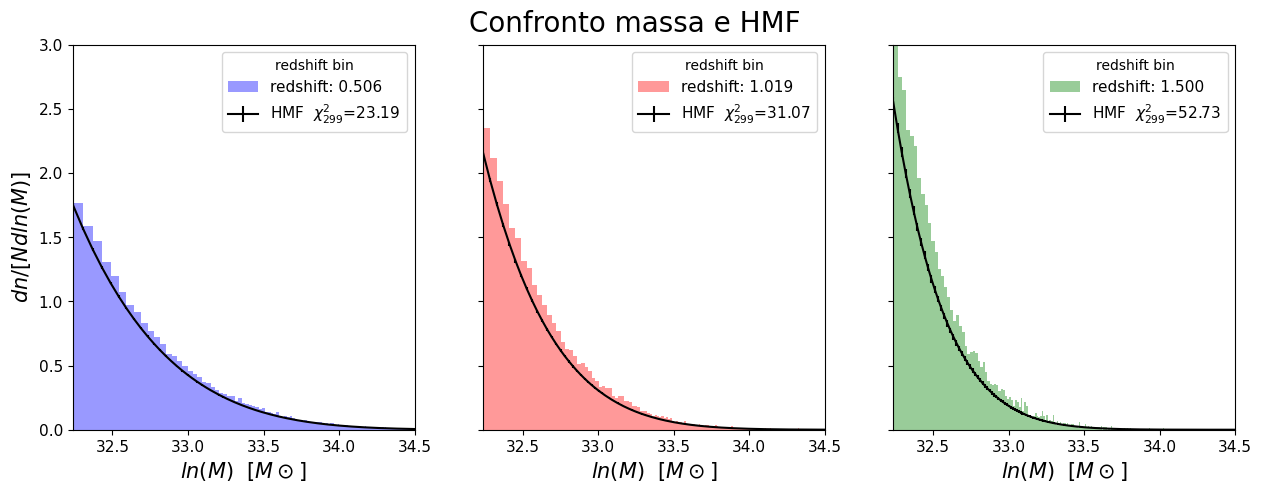

In [196]:
#Costruisco i plot
fig, ax  = plt.subplots(1, 3,figsize=(15, 5),sharey = True)
fig.suptitle('Confronto massa e HMF',fontsize = 20, y=0.95)

i = 0
chiq = np.array([0,0,0])

while i < 3: 
    #chiamo la funzione per calcolare il chi quadro del test di Pearson
    teo = mfunc(xarr[i],z[i],vol[i],N[i])
    std = np.sqrt(teo*(1/(N[i]*dx[i])))    #varianza della distribuzione teorica
    chiq[i] = chiquad(teo,counts[i],N[i],dx[i],std)
    chi_rid = chiq/(len(bins[i]))     #divido per il numero di bins, in questo modo ottengo il valore ridotto del chi quadro (non ho parametri stimati)

    ax[i].hist(np.log(mass[i]),bins=bins[i],density =True,color=color[i],alpha=0.4,label=f'redshift: {z[i]:.3f}') 
    ax[i].errorbar(bins[i], mfunc(xarr[i],z[i],vol[i],N[i]),color='black',label = 'HMF  $\\chi_{{{}}}^2$={:.2f}'.format(len(bins[i]), chi_rid[i]),yerr = np.sqrt(mfunc(xarr[i],z[i],vol[i],N[i])*(1/(N[i]*dx[i]))))
    
    ax[i].legend(title = "redshift bin",prop={'size': 11})
    ax[0].set_ylabel("$dn/[Ndln(M)]}$", fontsize=15)
    ax[i].set_xlabel("$ln(M)$  [$M\odot$]", fontsize=15)
    ax[i].tick_params(axis='x', labelsize=11)
    ax[i].tick_params(axis='y', labelsize=11)
    ax[i].set_xlim([bins[i,0], 34.5])
    ax[i].set_ylim(0, 3)
    
    i = i+1



I valori di $\chi^2$ ridotto ottenuti risultano essere molto maggiori di 1, in particolare per le distribuzioni nel redshift 1.019 e 1.5.\
Dato che le predizione teoriche sembrano seguire abbastanza bene l'andamento delle distribuzioni osservate, il valore alto del $\chi^2$ può essere giustificato dalla sottostmia dell'errore associato ai valori teorici.\
Infatti nel calcolo dell'errore si è assunto che i parametri cosmologici utilizzati siano assoluti.

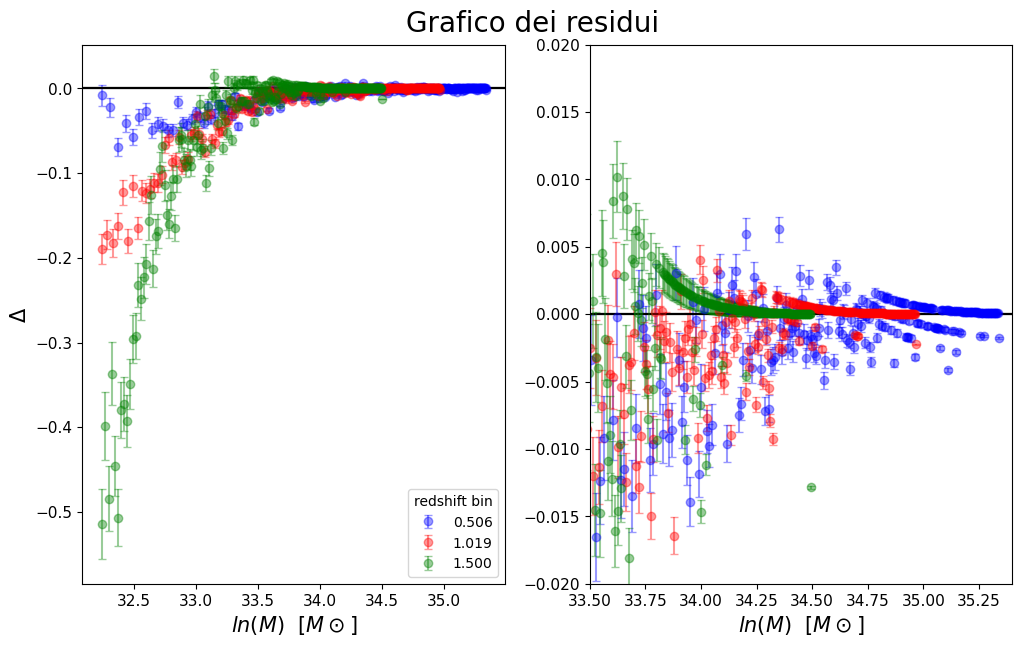

In [197]:
#Costruisco il plot dei residui
fig, ax = plt.subplots(1, 2,figsize=(12, 7))
fig.suptitle('Grafico dei residui',fontsize = 20,y=0.93)
i = 0
while i<3:
    
    ax[0].axhline(0,color = 'black')
    ax[0].errorbar(bins[i],(mfunc(xarr[i],z[i],vol[i],N[i])-counts[i]), fmt='o',capsize=3,label ='{:.3f}'.format(z[i]),color = color[i],alpha = 0.4,yerr= np.sqrt(mfunc(xarr[i],z[i],vol[i],N[i])*(1/(N[i]*dx[i]))))
    
    ax[0].legend(title = "redshift bin",prop={'size': 10}) 
    ax[0].set_ylabel("$\Delta$", fontsize=15)
    ax[0].set_xlabel("$ln(M)$  [$M\odot$]", fontsize=15)
    ax[0].tick_params(axis='x', labelsize=11)
    ax[0].tick_params(axis='y', labelsize=11)

    #zoom sulle code
    ax[1].axhline(0,color='black')
    ax[1].errorbar(bins[i],(mfunc(xarr[i],z[i],vol[i],N[i])-counts[i]), fmt='o',capsize=3,label ='{:.3f}'.format(z[i]),color = color[i],alpha = 0.4,yerr= np.sqrt(mfunc(xarr[i],z[i],vol[i],N[i])*(1/(N[i]*dx[i]))))
    
    ax[1].set_ylim([-0.02, 0.02]) 
    ax[1].set_xlim([33.5, 35.4])  
    ax[1].set_xlabel("$ln(M) $  [$M\odot$]", fontsize=15)
    ax[1].tick_params(axis='x', labelsize=11)
    ax[1].tick_params(axis='y', labelsize=11)
    i = i+1



 $\Delta =\rho_t - \rho_o$ 

Come predetto dal test del $\chi^2$ si osserva che la maggior parte dei dati non risulta compatibili.

Inoltre l'andamento dei valori nel range [32.5 , 33.5] potrebbe suggerire la presenza di un errore sistematico propagato nel modello che causa la sottostima della predizione.

In conclusione è possibile affermare che l'andamento dei dati viene approssimato dall'andamento della distribuzione teorica; si osserva che tale modello varia molto nei 3 redshift e con esso l'imprecisione della predizione.\
Procedendo con dell'inferenza Bayesiana sui parametri cosmologici che compongono il modello sarà possibile trovare più informazioni sui parametri, in questo modo sarà possibile descrivere al meglio la distribuzione osservata.

## 3. Stima dei parametri
Mediante **l'nferenza Bayesiana** è possibile studiare i parametri cosmologici in modo da ottenere una loro distribuzione chiamata Posterior.\
L'obbiettivo dell'analisi è quello di stimare $Om0$ (densità di materia) e $\sigma_8$ (ampiezza delle fluttuazioni di densità).

I dati sono stati analizzati mediante l'algoritmo **EMCEE**.\
Tale algoritmo utilizza dei walkers per esplorare lo spazio dei parametri determinato dal prodotto tra l'ipotesi iniziale fatta sui parametri (Prior) e la probabilità di osservare i dati fatta l'ipotesi sui parametri (Likelihood). \
Non avendo alcuna informazione sui parametri la prior è stata presa piatta in un intervallo tra $ [0.1 , 1.0]$ , mentre la Likelihood è quella di una distribuzione di Poisson.\
$$L(n,\theta) = \prod_{i} \frac{e^{-\lambda}}{ n!}\lambda^{n} $$ \
$$ln(L(n,\theta)) = \Sigma_{i}  ln(\frac{e^{-\lambda}}{ n!}\lambda^{n}) $$

Dove $n$ sono i valori osservati mentre $\lambda$ sono i valori teorici calcolati con HMF, entrambi espressi in $\frac{dn}{Ndln(M)}$ 

Segue l'implementazione dell'algoritmo.

In [198]:
def log_prior(theta):   #Prior piatta tra [0.1,1.0] 
    x, y = theta
    if(0.1<x<1.0 and 0.1<y<1.0):
        return 0.0
    return -np.inf

def model(theta,xarr,z,vol,N):    #questa funzione descrive sempre la HMF ma in questo caso ho 2 parametri da stimare, x e y
    x, y = theta
    params = {'flat': True, 'H0': 67.77, 'Om0': x, 'Ob0': 0.049,'sigma8': y, 'ns': 0.96}
    cosmology.addCosmology('myCosmo', params)
    cosmo = cosmology.setCosmology('myCosmo')
    return ((mass_function.massFunction(xarr, z, mdef='vir',model='despali16', q_out='dndlnM')*vol)/N)


def log_likelihood(theta,xarr,z,vol,N,count):    #Likelihood nell'ipotesi che l'andamento sia descritto da una distribuzione di Poisson
    x, y = theta
    model_ = model(theta,xarr,z,vol,N)
    likel = np.nansum(np.log((np.exp(-model_))*(model_**count)/(factorial(count, exact=False)))) 
    return likel

def log_posterior(theta,xarr,z,vol,N,count):    #log(Posterior) = log(Prior) + log(Likelihood)
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta,xarr,z,vol,N,count)


In [199]:
np.random.seed(42)
initial = np.array([0.3,0.7]) * (1 + 0.1*np.random.randn(2)) 

pos = [0,0,0]

i = 0
while i<3:
    nll = 0
    nll = lambda *args: -log_posterior(*args)
    
    soln = minimize(nll, initial, args=(xarr[i],z[i],vol[i],N[i],counts[i]))
    pos[i] = [soln.x]
    i = i+1

bestf = np.array(pos)   #Valori di BestFit

bestf1 = bestf[0].reshape(-1)
bestf2 = bestf[1].reshape(-1)
bestf3 = bestf[2].reshape(-1)

C:\Users\valer.PC1\anaconda3\envs\prova\lib\site-packages\scipy\optimize\_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
C:\Users\valer.PC1\anaconda3\envs\prova\lib\site-packages\scipy\optimize\_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
C:\Users\valer.PC1\anaconda3\envs\prova\lib\site-packages\scipy\optimize\_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
C:\Users\valer.PC1\anaconda3\envs\prova\lib\site-packages\scipy\optimize\_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
C:\Users\valer.PC1\anaconda3\envs\prova\lib\site-packages\scipy\optimize\_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
C:\Users\valer.PC1\anaconda3\envs\prova\lib\site-packages\scipy\optimize\_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0


In [173]:
#-----------Primo redshift--------
bestf1 = bestf[0].reshape(-1)

pos1 = bestf1*(1+ 1e-4*np.random.randn(30,2))    #30 walkers
nwalkers, ndim = pos1.shape

#commento il run_mcmc per permettere all'utente di fare "Run all cells" (visto il costo computazionale)
sampler1 = emcee.EnsembleSampler(nwalkers, ndim, log_posterior, args=(xarr[0],z[0],vol[0],N[0],counts[0]))
#sampler1.run_mcmc(pos1, 1000, progress=True);

#Dato il costo computazionale salvo i file
np.save('chain1.npy', sampler1.get_chain())
np.save('chain1_red.npy', sampler1.get_chain(discard=100, flat=True))


100%|██████████| 1000/1000 [1:28:52<00:00,  5.33s/it]


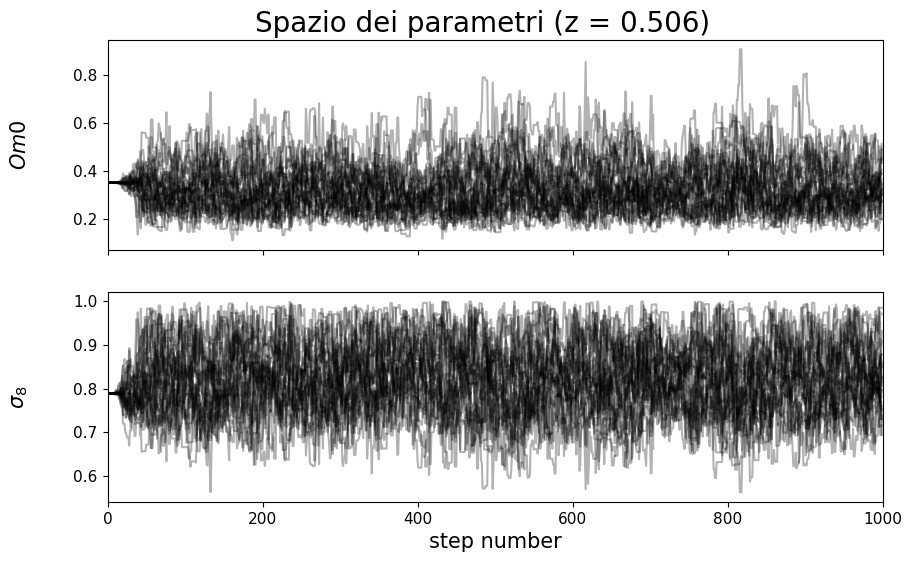

In [200]:
#samples1 = sampler1.get_chain()
samples1 = np.load('chains/chain1.npy')

fig, axes = plt.subplots(2, figsize=(10, 6), sharex=True)
labels = ["$Om0$", "$\sigma_8$"]
fig.suptitle('Spazio dei parametri (z = {})'.format(z[0]),fontsize = 20,y=0.93)

ndim=2
for i in range(2):
    ax = axes[i]
    ax.plot(samples1[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples1))
    ax.set_ylabel(labels[i], fontsize=15)
    ax.yaxis.set_label_coords(-0.1, 0.5)
    ax.tick_params(axis='x', labelsize=11)
    ax.tick_params(axis='y', labelsize=11)


axes[-1].set_xlabel("step number",fontsize=15);

samples1 = np.load('chains/chain1_red.npy')

Om01 = np.mean(samples1[:,0])        #Calcolo valore medio e deviazione standard
stdOm01 = np.std(samples1[:,0])
sigma81 = np.mean(samples1[:,1])
stdsigma81 = np.std(samples1[:,1])

In [9]:
#-----------Secondo redshift--------
bestf2 = bestf[1].reshape(-1)

pos2 = bestf2*(1+ 1e-4*np.random.randn(30,2))    #30 walkers
nwalkers, ndim = pos2.shape

#commento il run_mcmc per permettere all'utente di fare "Run all cells" (visto il costo computazionale)
sampler2 = emcee.EnsembleSampler(nwalkers, ndim, log_posterior, args=(xarr[1],z[1],vol[1],N[1],counts[1]))
#sampler2.run_mcmc(pos2, 1000, progress=True);

#Dato il costo computazionale salvo i file
np.save('chain2.npy', sampler2.get_chain())
np.save('chain2_red.npy', sampler2.get_chain(discard=100, flat=True))

100%|██████████| 1000/1000 [1:16:07<00:00,  4.57s/it]


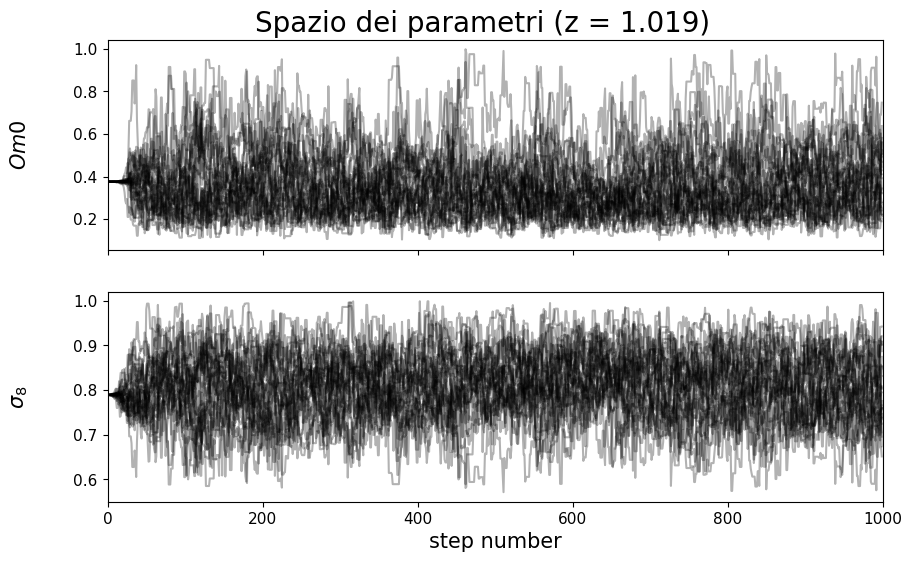

In [228]:
#samples2 = sampler2.get_chain()
samples2 = np.load('chains/chain2.npy')

fig, axes = plt.subplots(2, figsize=(10, 6), sharex=True)
labels = ["$Om0$", "$\sigma_8$"]
fig.suptitle('Spazio dei parametri (z = {})'.format(z[1]),fontsize = 20,y=0.93)

for i in range(2):
    ax = axes[i]
    ax.plot(samples2[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples2))
    ax.set_ylabel(labels[i],fontsize=15)
    ax.yaxis.set_label_coords(-0.1, 0.5)
    ax.tick_params(axis='x', labelsize=11)
    ax.tick_params(axis='y', labelsize=11)

axes[-1].set_xlabel("step number",fontsize=15);

samples2 = np.load('chains/chain2_red.npy')
Om02 = np.mean(samples2[:,0])                   #Calcolo valore medio e deviazione standard
stdOm02 = np.std(samples2[:,0])
sigma82 = np.mean(samples2[:,1])
stdsigma82 = np.std(samples2[:,1])

In [11]:
#-----------Terzo redshift--------
bestf3 = bestf[2].reshape(-1)

pos3 = bestf3*(1+ 1e-4*np.random.randn(30,2))    #32 walkers
nwalkers, ndim = pos3.shape

#commento il run_mcmc per permettere all'utente di fare "Run all cells" (visto il costo computazionale)
sampler3 = emcee.EnsembleSampler(nwalkers, ndim, log_posterior, args=(xarr[2],z[2],vol[2],N[2],counts[2]))
#sampler3.run_mcmc(pos3, 1000, progress=True);

#Dato il costo computazionale salvo i file
np.save('chain3.npy', sampler3.get_chain())
np.save('chain3_red.npy', sampler3.get_chain(discard=100, flat=True))

100%|██████████| 1000/1000 [1:17:08<00:00,  4.63s/it]


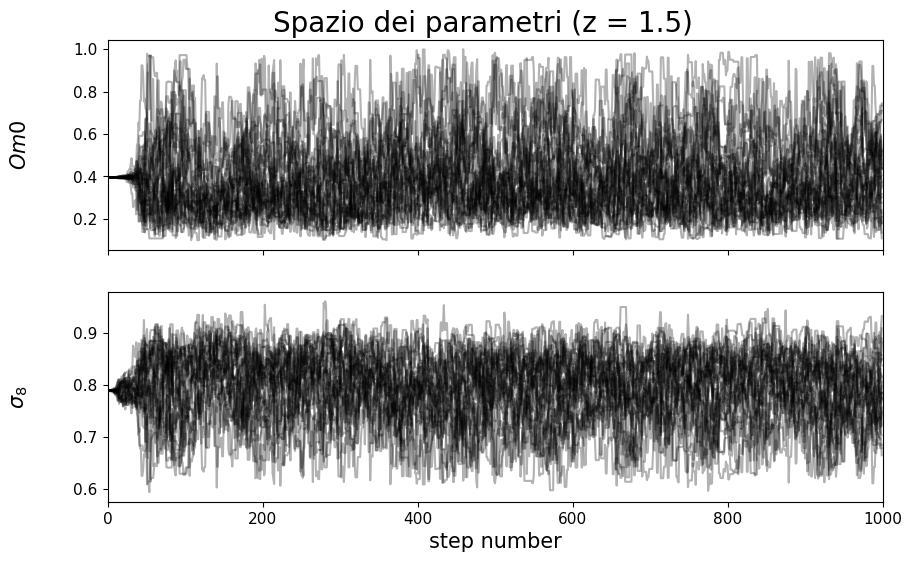

In [227]:
#samples3 = sampler3.get_chain()
samples3 = np.load('chains/chain3.npy')

fig, axes = plt.subplots(2, figsize=(10, 6), sharex=True)
labels = ["$Om0$", "$\sigma_8$"]
fig.suptitle('Spazio dei parametri (z = {})'.format(z[2]),fontsize = 20,y=0.93)

for i in range(2):
    ax = axes[i]
    ax.plot(samples3[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples3))
    ax.set_ylabel(labels[i],fontsize=15)
    ax.yaxis.set_label_coords(-0.1, 0.5)
    ax.tick_params(axis='x', labelsize=11)
    ax.tick_params(axis='y', labelsize=11)

axes[-1].set_xlabel("step number",fontsize=15);

samples3 = np.load('chains/chain3_red.npy')

Om03 = np.mean(samples3[:,0])           #Calcolo valore medio e deviazione standard
stdOm03 = np.std(samples3[:,0])
sigma83 = np.mean(samples3[:,1])
stdsigma83 = np.std(samples3[:,1])

Dall'algoritmo sono stati ricavati i seguenti valori medi e deviazione dei parametri:

In [205]:
#raccolgo in vettori i valori di media e deviazione ottenuti
mean_Om0 = np.array([Om01,Om02,Om03])
deviazione_Om0 = np.array([stdOm01,stdOm02,stdOm03])

mean_sigma8 = np.array([sigma81,sigma82,sigma83])
deviazione_sigma8 = np.array([stdsigma81,stdsigma82,stdsigma83])

i = 0
while i<3:
    print("-----------------------------------")
    print("L'analisi di z = {} ottiene: ".format(z[i]))
    print("")
    print("Om0 = {:.2f}, std_Om0 = {:.2f}".format(mean_Om0[i],deviazione_Om0[i]))
    print("sigma8 = {:.2f}, std_sigma8 = {:.2f}".format(mean_sigma8[i],deviazione_sigma8[i]))
    print("-----------------------------------")
    i = i+1

-----------------------------------
L'analisi di z = 0.506 ottiene: 

Om0 = 0.33, std_Om0 = 0.10
sigma8 = 0.82, std_sigma8 = 0.08
-----------------------------------
-----------------------------------
L'analisi di z = 1.019 ottiene: 

Om0 = 0.35, std_Om0 = 0.14
sigma8 = 0.81, std_sigma8 = 0.07
-----------------------------------
-----------------------------------
L'analisi di z = 1.5 ottiene: 

Om0 = 0.39, std_Om0 = 0.17
sigma8 = 0.80, std_sigma8 = 0.06
-----------------------------------


Seguono le analisi per i dati raccolti nei singoli bin di redshift.

In [206]:
def model(x,y,xarr,z,vol,N):
    params = {'flat': True, 'H0': 67.77, 'Om0': x, 'Ob0': 0.049,'sigma8': y, 'ns': 0.96}
    cosmology.addCosmology('myCosmo', params)
    cosmo = cosmology.setCosmology('myCosmo')
    return ((mass_function.massFunction(xarr, z, mdef='vir',model='despali16', q_out='dndlnM')*vol)/N)

def fun(x,mean,std):
    return norm.pdf(x, loc=mean, scale=std) 



#Calcolo i rapporti incrementali per propagare la varianza sulla curva teorica

def d_funOm0(x,y,xarr,z,vol,N):
    h = 1e-8 
    return (model(x+h,y,xarr,z,vol,N)-model(x,y,xarr,z,vol,N))/h


def d_funsigma8(x,y,xarr,z,vol,N):
    h = 1e-8
    return (model(x,y+h,xarr,z,vol,N)-model(x,y,xarr,z,vol,N))/h


### 3.1 Stima parametri per z=0.506


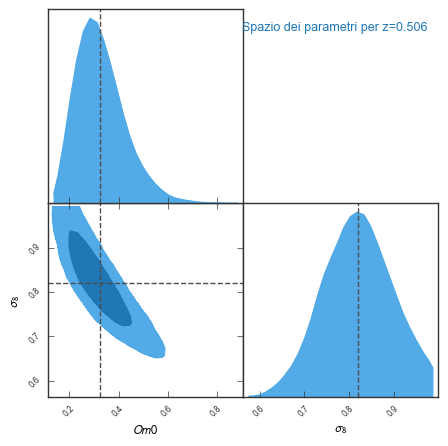

In [207]:
GTC = pygtc.plotGTC(chains=samples1,
                    paramNames=['$Om0$','$\sigma_8$'],
                    chainLabels=['Spazio dei parametri per z={}'.format(z[0])],
                    figureSize='MNRAS_page',
                    truths=[mean_Om0[0], mean_sigma8[0]],)

In questo plot è possibile osservare la distribuzine bidimensionale dei parametri e le relative distribuzioni marginali; si nota che i due parametri sono molto correlati dunque il coefficiente di correlazione tenderà a - 1.

Per quanto riguarda le distribuzioni marginali si nota l'asimmetria per la distribuzione di $Om0$ e la simmetria di $\sigma_8$ (sembrerebbe seguire una distribuzione Gaussiana).

Per un'analisi migliore si procede istogrammando le distribuzioni marginali su cui si possono trovare i valori del 16°,50° e 84° percentile ed il valore medio; utili per valutare l'asimmetria.\
Se l'asimmetria è marcata sarà conveniente utilizzare il valore mediano al posto del valore medio per la stima del parametro, questo infatti è un valore più robusto in quanto non viene influenzato dalle code; in ogni caso è conveniente provare a fittare le distribuzioni con delle gaussiane.

Parametro Om0
Valore mediano: 0.31
Errore superiore : 0.11
Errore inferiore : 0.08
----------------------
Parametro sigma8
Valore mediano: 0.82
Deviazione : 0.08
----------------------
Coefficiente di correlazione : -0.90
----------------------
Best fit
Om0 = 0.38
sigma8 = 0.77
----------------------


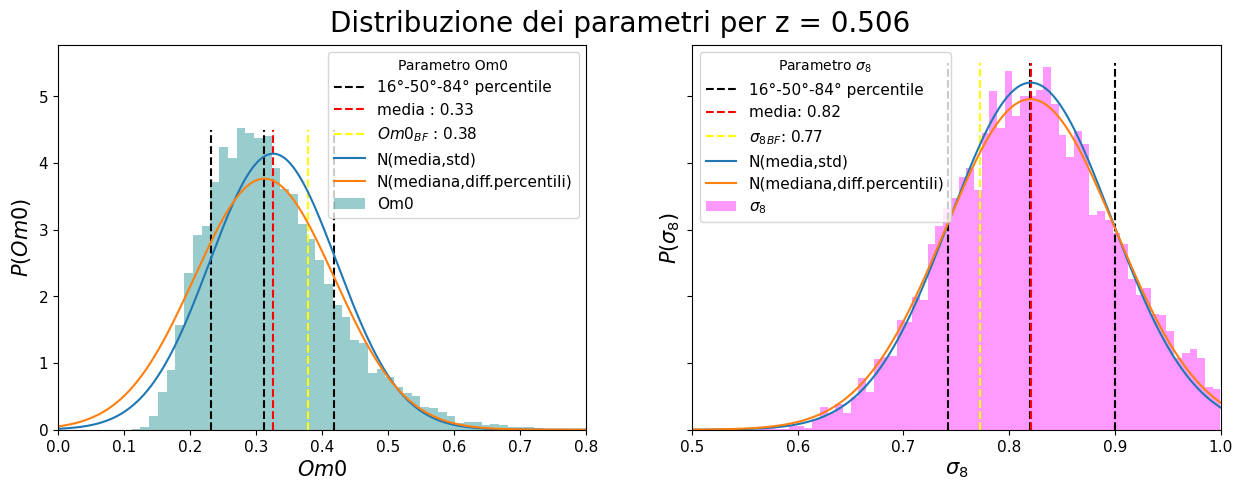

In [209]:
#Calcolo i percentili
Om0_perc1 = np.percentile(samples1[:, 0], [16, 50, 84])
sigma8_perc1 = np.percentile(samples1[:, 1], [16, 50, 84])

#----------------------------------------------------------
#Costruisco il grafico
color1 = ['teal','Magenta']
string = ['Om0','$\sigma_8$']
fig, ax  = plt.subplots(1, 2,figsize=(15, 5),sharey = True)
fig.suptitle('Distribuzione dei parametri per z = {}'.format(z[0]),fontsize = 20, y=0.95)


#Condizione if sui percentili per plottare la legenda solo una volta
i = 0
while i<3:
    if i == 0:
        ax[0].vlines(Om0_perc1[i],0,4.5, colors="black", linestyles="dashed", label='16°-50°-84° percentile')
        ax[1].vlines(sigma8_perc1[i],0,5.5, colors="black", linestyles="dashed",label='16°-50°-84° percentile')
    else:
        ax[1].vlines(sigma8_perc1[i],0,5.5, colors="black", linestyles="dashed")
        ax[0].vlines(Om0_perc1[i],0,4.5, colors="black", linestyles="dashed")
        
    i = i+1


#Plotto il valore medio calcolato dal samples precedentemente
ax[0].vlines(mean_Om0[0],0,4.5, colors="red", linestyles="dashed",label='media : {:.2f}'.format(mean_Om0[0]))
ax[1].vlines(mean_sigma8[0],0,5.5, colors="red", linestyles="dashed",label='media: {:.2f}'.format(mean_sigma8[0]))

#plot del valore di bestfit
ax[0].vlines(bestf1[0],0,4.5, colors="yellow", linestyles="dashed",label='${}_{{BF}}$ : {:.2f}'.format(string[0],bestf1[0]))
ax[1].vlines(bestf1[1],0,5.5, colors="yellow", linestyles="dashed",label='{}$_{{BF}}$: {:.2f}'.format(string[1],bestf1[1]))

#----------------------------------------------------------

#Calcolo la deviazione prendendo il massimo valore tra la differenza dei due percentili (16,84) con il valore mediano (sovrastima se è asimmetrica)
devOm01 = np.maximum((Om0_perc1[1]-Om0_perc1[0]),(Om0_perc1[2]-Om0_perc1[1]))
devsigma81 = np.maximum((sigma8_perc1[1]-sigma8_perc1[0]),(sigma8_perc1[2]-sigma8_perc1[1]))

#----------------------------------------------------------

#Provo a fittare della gaussiane centrate nel valore medio o mediano
x = np.linspace(-1.0,1.0,len(samples1))
ax[1].plot(x,fun(x,mean_sigma8[0],deviazione_sigma8[0]),label='N(media,std)')
ax[1].plot(x,fun(x,sigma8_perc1[1],devsigma81),label='N(mediana,diff.percentili)')
ax[1].set_xlim([0.5, 1.])

ax[0].plot(x,fun(x,mean_Om0[0],deviazione_Om0[0]),label='N(media,std)')
ax[0].plot(x,fun(x,Om0_perc1[1],devOm01),label='N(mediana,diff.percentili)')
ax[0].set_xlim([0.0, 0.8])

#----------------------------------------------------------

i = 0
while i < 2:
    ax[i].hist(samples1[:,i], bins=60, density=True,color=color1[i],alpha=0.4,label = string[i])
    ax[0].set_xlabel("$Om0$", fontsize=15)
    ax[1].set_xlabel("$\sigma_{8}$", fontsize=15)
    ax[i].tick_params(axis='x', labelsize=11)
    ax[i].tick_params(axis='y', labelsize=11)
    ax[i].legend(title = "Parametro {}".format(string[i]),prop={'size': 11})
    i = i+1

ax[0].set_ylabel("$P(Om0)$", fontsize=15)
ax[1].set_ylabel("$P(\sigma_{8})$", fontsize=15)

#----------------------------------------------------------

#Calcolo il coefficiente di Correlazione
r1 = np.corrcoef(samples1[:,0], samples1[:,1])[0, 1]

#----------------------------------------------------------

#Calcolo l'intervallo di confidenza per Om0
Om0inf1 = Om0_perc1[1]-Om0_perc1[0]
Om0sup1 = Om0_perc1[2]-Om0_perc1[1]

#----------------------------------------------------------

print("Parametro Om0")
print("Valore mediano: {:.2f}".format(Om0_perc1[1]))
print("Errore superiore : {:.2f}".format(Om0sup1))
print("Errore inferiore : {:.2f}".format(Om0inf1))
print("----------------------")
print("Parametro sigma8")
print("Valore mediano: {:.2f}".format(sigma8_perc1[1]))
print("Deviazione : {:.2f}".format(deviazione_sigma8[0]))
print("----------------------")
print("Coefficiente di correlazione : {:.2f}".format(r1))
print("----------------------")
print("Best fit")
print("Om0 = {:.2f}".format(bestf1[0]))
print("sigma8 = {:.2f}".format(bestf1[1]))
print("----------------------")

Nel grafico sono riportate due gaussiane:
- $N(media,std)$ è stata realizzata utilizzando la media come valore centrale e la deviazione calcolata dai dati del parametro mediante numpy.std
- $N(mediana,diff.percentili)$ è stata calcolata utilizzando la mediana come valore centrale e deviazione pari al valore massimo tra la differenza dei percentili 16° e 84° con il 50° (nel caso di distribuzioni asimmetriche rappresenta una sovrastima dell'errore ma è più facile da trattare).



Dal grafico delle due distribuzioni si nota che la distribuzione di $Om0$ non è Gaussiana, infatti è una distribuzione asimmetrica; pertanto, per evitare di far pesare eccessivamente le code sul valore medio del parametro, si utilizzerà il valore mediano.\
Per quanto riguarda la deviazione sarà necessario distrigunere l'intervallo di confidenza determinato dai percentili.


La distribuzione di $\sigma_8$ è invece simmetrica, quindi rappresentabile da una Gaussiana con valore centrale pari al valore medio o al valore mediano (combaciano per simmetria).\
Dunque, dallo studio della distribuzione dei parametri, si ricavano le seguenti stime:

$$ Om0_1 = 0.31 ^{0.11}_{0.08}$$ 
$$ \sigma_{8_1} = 0.82 \quad \sigma_{\sigma_{8_{1}}} =  0.08 $$

Mentre il coefficiente di correlazione risulta essere:
$$r_1 = -0.90 $$
Il valore corrisponde ad una quasi perfetta correlazione lineare negativa ,come predetto dal grafico della distribuzione bidimensionale.

Il valore di best fit, ricavato minimizzando la posterior, risulta compatibile entro una deviazione con il valore mediano dei parametri.

Avendo trovato i valori medi/mediani dei parametri, è possibile confrontare la funzione teorica HMF con la distribuzione di massa osservata;  per determinare l'intervallo di confidenza è necessario propagare l'errore sulla funzione HMF, ovvero:
$$ \sigma^2_{\rho_t} = (\frac{\delta \rho_t}{\delta Om0})^2 \sigma^2_{Om0}+(\frac{\delta \rho_t}{\delta \sigma_8})^2 \sigma^2_{\sigma_{8}} + 2cov(Om0,\sigma_8)(\frac{\delta \rho_t}{\delta Om0})(\frac{\delta \rho_t}{\delta \sigma_8})$$
Le derivate sono state calcolate mediante il rapporto incrementale implementato in d_funOm0 e d_funsigma8.

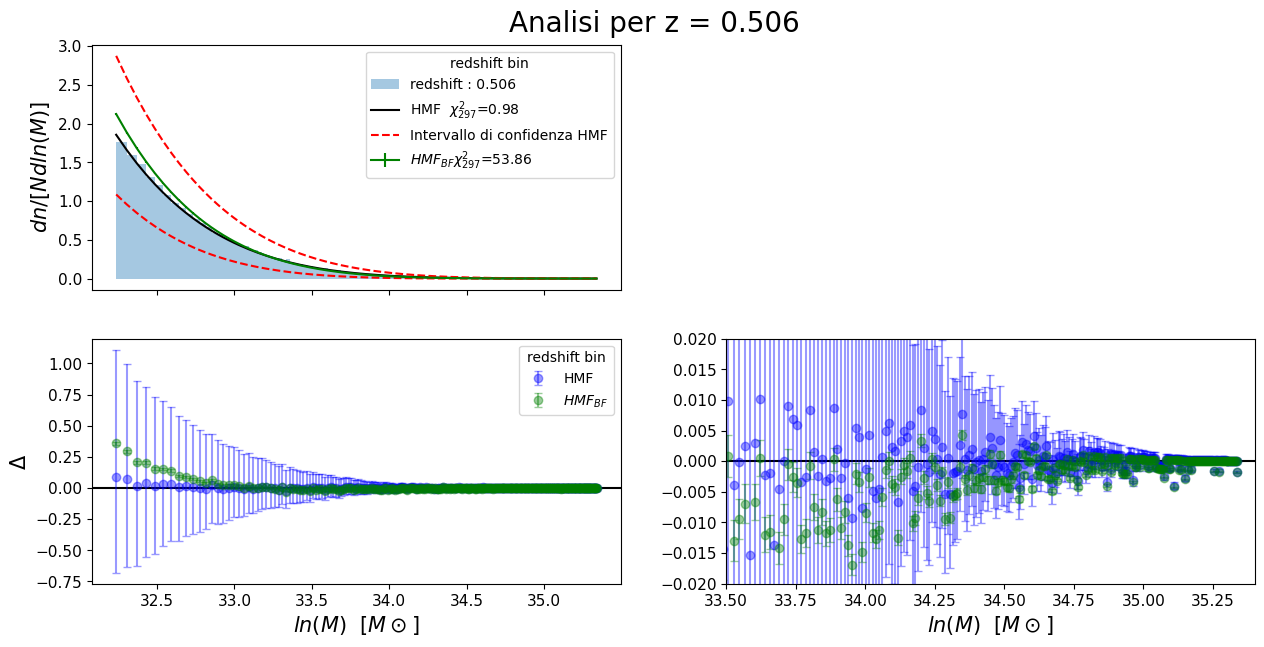

In [210]:
#Derivate per propagare l'errore sulla funzione teorica
der1 = d_funOm0(Om0_perc1[1],sigma8_perc1[1],xarr[0],z[0],vol[0],N[0])

der2 = d_funsigma8(Om0_perc1[1],sigma8_perc1[1],xarr[0],z[0],vol[0],N[0])

HMF_devSup1 = np.sqrt((der1*Om0sup1)**2+(der2*devsigma81)**2 +2*(der1*der2*devsigma81*Om0sup1*r1))  #errore superiore
HMF_devInf1 = np.sqrt((der1*Om0inf1)**2+(der2*devsigma81)**2 +2*(der1*der2*devsigma81*Om0inf1*r1))  #errore inferiore

#Costruisco il plot
fig, ax = plt.subplots(2, 2,figsize=(15, 7),sharex='col')
fig.suptitle('Analisi per z = {}'.format(z[0]),fontsize = 20,y=0.93)

#Funzioni principali
yerr = [HMF_devInf1,HMF_devSup1]     #considero l'errore inferiore e superiore
delta = model(Om0_perc1[1],sigma8_perc1[1],xarr[0],z[0],vol[0],N[0])-counts[0]

#Valori di best fit
Om0_perc1bf = bestf1[0]
sigma8_perc1bf = bestf1[1]

yerrbf = np.sqrt(model(Om0_perc1bf,sigma8_perc1bf,xarr[0],z[0],vol[0],N[0])*(1/(N[0]*dx[0])))  
deltabf = model(Om0_perc1bf,sigma8_perc1bf,xarr[0],z[0],vol[0],N[0])-counts[0]

#--------------------------------------------------------------------------------------

#Calcolo il chi quadro
teo = model(Om0_perc1[1],sigma8_perc1[1],xarr[0],z[0],vol[0],N[0])
oss = counts[0]
chiq = chiquad(teo,oss,N[0],dx[0],np.maximum(HMF_devInf1,HMF_devSup1))   #Prendo il massimo tra i due
chi_rid = (chiq/(len(bins[0]-2)))     #Tengo conto della stima dei 2 parametri

#Chi quadro best fit


teobf = model(Om0_perc1bf,sigma8_perc1bf,xarr[0],z[0],vol[0],N[0])
chiqbf = chiquad(teobf,oss,N[0],dx[0],yerrbf)
chi_ridbf = (chiqbf/(len(bins[0]-2)))     #Tengo conto della stima dei 2 parametri

#--------------------------------------------------------------------------------------


ax[0,0].hist(np.log(mass[0]),density=True,bins=bins[0,:],label="redshift : {}".format(z[0]),alpha=0.4) 
ax[0,0].plot(bins[0,:],model(Om0_perc1[1],sigma8_perc1[1],xarr[0],z[0],vol[0],N[0]),color='black',label='HMF  $\\chi_{{{}}}^2$={:.2f}'.format(len(bins[0])-2, chi_rid))
ax[0,0].errorbar(bins[0,:],model(Om0_perc1bf,sigma8_perc1bf,xarr[0],z[0],vol[0],N[0]),color='green',label='$HMF_{{BF}}\chi_{{{}}}^2$={:.2f}'.format(len(bins[0])-2, chi_ridbf),yerr=yerrbf)
#Intervallo di confidenza di HMF
ax[0,0].plot(bins[0,:],model(Om0_perc1[1],sigma8_perc1[1],xarr[0],z[0],vol[0],N[0]) + HMF_devSup1 ,color='red',linestyle="--",label='Intervallo di confidenza HMF')
ax[0,0].plot(bins[0,:],model(Om0_perc1[1],sigma8_perc1[1],xarr[0],z[0],vol[0],N[0]) - HMF_devInf1,color='red',linestyle="--")


ax[0,0].set_ylabel("$dn/[Ndln(M)]}$", fontsize=15)
ax[0,0].legend(title = "redshift bin",prop={'size': 10})
ax[0,0].tick_params(axis='x', labelsize=11)
ax[0,0].tick_params(axis='y', labelsize=11)

#--------------------------------------------------------------------------------------

ax[0,1].axis('off')

#--------------------------------------------------------------------------------------

ax[1,0].axhline(0,color = 'black')
ax[1,0].errorbar(bins[0,:],delta,fmt='o',capsize=3,label='HMF',color = color[0],alpha = 0.4,yerr= yerr)
ax[1,0].errorbar(bins[0,:],deltabf, yerr = yerrbf,fmt='o',capsize=3,color='green',alpha=0.4,label='$HMF_{BF}$')

ax[1,0].set_ylabel("$\Delta$", fontsize=15)
ax[1,0].set_xlabel("$ln(M)$  [$M\odot$]", fontsize=15)
ax[1,0].legend(title = "redshift bin",prop={'size': 10})


#--------------------------------------------------------------------------------------

ax[1,1].axhline(0,color = 'black')
ax[1,1].errorbar(bins[0,:],delta, fmt='o',capsize=3,color = color[0],alpha = 0.4,yerr= yerr)
ax[1,1].errorbar(bins[0,:],deltabf,yerr = yerrbf,fmt='o',capsize=3,color='green',alpha=0.4,label='$HMF_{BF}$')

ax[1,1].set_xlabel("$ln(M)$  [$M\odot$]", fontsize=15)
ax[1,1].set_ylim([-0.02, 0.02]) 
ax[1,1].set_xlim([33.5, 35.4])  

#-----------------------------------------------------------------------

i = 0
while i<2:
    ax[1,i].tick_params(axis='x', labelsize=11)
    ax[1,i].tick_params(axis='y', labelsize=11)
    i = i+1


$\Delta$ rappresenta la differenza tra valori teorici e valori misurati.

Nel primo grafico è riportato il confronto tra valori osservati (blu), $HMF_{BF}$ teorica relativi ai parametri di best fit (verde) con errore pari $\sigma_{\rho_t}^2 = \frac{\rho_t}{Ndln(M)}$ e HMF teorica relativa ai parametri stimati dalla posterior (nero) con relativo intervallo di confidenza pari ad 1 deviazione standard (rosso tratteggiato).


Entrambi i modelli proposti sembrano seguire l'andamento dei dati osservati.\
Utilizzando i parametri di best fit la distribuzione risulta sovrastimata, ragionevole dato che il valore si trova a circa mezza deviazione standard dal valore mediano e medio per entrambi i parametri; ciò viene confermato dal chi quadro ridotto che risulta superiore rispetto al valore ottenuto con i parametri forniti dalla libreria a parità d'errore ($\chi^2 \approx 23$).\
Dunque i valori di best fit non sono una buona stima dei parametri.


Invece la predizione di HMF che è stata calcolata utilizzando i valori mediani determinati dallo studio della posterior dei parametri, risulta seguire bene l'andamento dei dati; a conferma si osserva che il valore di $\chi^2$ è molto vicino a 1.\
Dunque i valori stimati dei parametri forniscono un buon modello teorico.

### 3.2 Stima parametri per z = 1.109


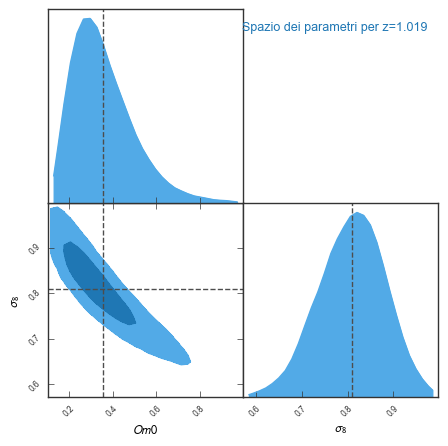

In [211]:
GTC = pygtc.plotGTC(chains=samples2,
                    paramNames=['$Om0$','$\sigma_8$'],
                    chainLabels=['Spazio dei parametri per z={}'.format(z[1])],                    
                    figureSize='MNRAS_page',
                    truths=[mean_Om0[1], mean_sigma8[1]])

Anche per questo redshift la correlazione tenderà a -1.\
Per quanto riguarda le distribuzioni marginalizzate si nota l'assimetria per la distribuzione di Om0 e la "quasi" simmetria di sigma8.

Parametro Om0
Valore mediano: 0.33
Errore superiore : 0.16
Errore inferiore : 0.11
----------------------
Parametro sigma8
Valore mediano: 0.81
Deviazione : 0.07
----------------------
Coefficiente di correlazione : -0.94
----------------------
Best fit
Om0 = 0.38
sigma8 = 0.78
----------------------


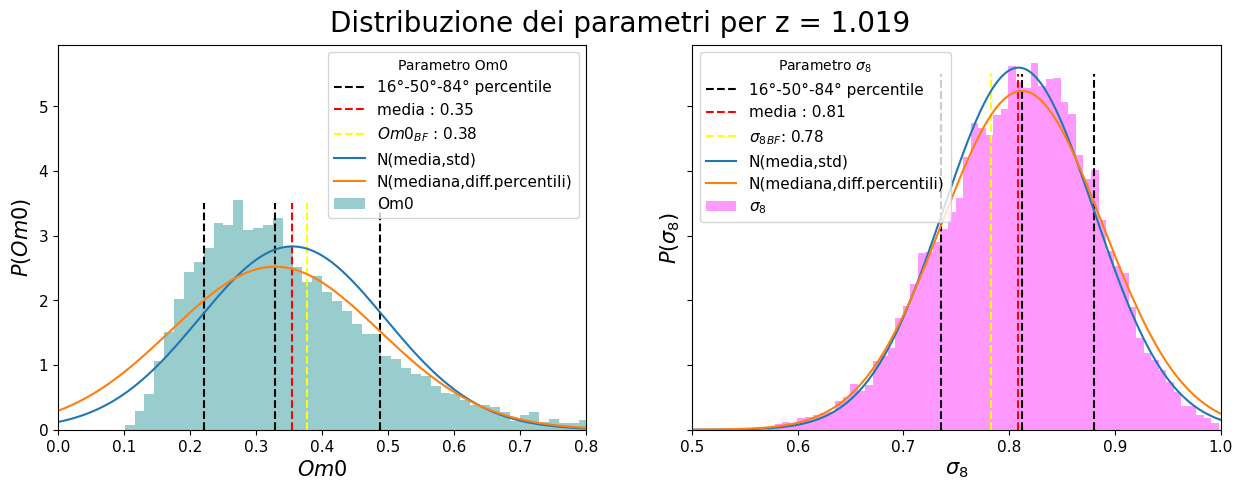

In [213]:
#Calcolo i percentili
Om0_perc2 = np.percentile(samples2[:, 0], [16, 50, 84])
sigma8_perc2 = np.percentile(samples2[:, 1], [16, 50, 84])

#--------------------------------------------------------------------------------------

#Costruisco il grafico
fig, ax  = plt.subplots(1, 2,figsize=(15, 5),sharey = True)
fig.suptitle('Distribuzione dei parametri per z = {}'.format(z[1]),fontsize = 20, y=0.95)
    

#Condizione if sui percentili per plottare la legenda solo una volta
i = 0
while i<3:
    if i == 0:
        ax[0].vlines(Om0_perc2[i],0,3.5, colors="black", linestyles="dashed", label='16°-50°-84° percentile')
        ax[1].vlines(sigma8_perc2[i],0,5.5, colors="black", linestyles="dashed",label='16°-50°-84° percentile')
    else:
        ax[1].vlines(sigma8_perc2[i],0,5.5, colors="black", linestyles="dashed")
        ax[0].vlines(Om0_perc2[i],0,3.5, colors="black", linestyles="dashed")
        
    i = i+1


#Plotto il valore medio calcolato dal samples precedentemente
ax[0].vlines(mean_Om0[1],0,3.5, colors="red", linestyles="dashed",label='media : {:.2f}'.format(mean_Om0[1]))
ax[1].vlines(mean_sigma8[1],0,5.5, colors="red", linestyles="dashed",label='media : {:.2f}'.format(mean_sigma8[1]))

#plot del valore di bestfit
ax[0].vlines(bestf2[0],0,3.5, colors="yellow", linestyles="dashed",label='${}_{{BF}}$ : {:.2f}'.format(string[0],bestf2[0]))
ax[1].vlines(bestf2[1],0,5.5, colors="yellow", linestyles="dashed",label='{}$_{{BF}}$: {:.2f}'.format(string[1],bestf2[1]))

#--------------------------------------------------------------------------------------

#Calcolo la deviazione prendendo il massimo valore tra la differenza dei due percentili (16,84) con il valore mediano
devOm02 = np.maximum((Om0_perc2[1]-Om0_perc2[0]),(Om0_perc2[2]-Om0_perc2[1]))
devsigma82 = np.maximum((sigma8_perc2[1]-sigma8_perc2[0]),(sigma8_perc2[2]-sigma8_perc2[1]))

#--------------------------------------------------------------------------------------

#Provo a fittare della gaussiane centrate nel valore medio o mediano
x = np.linspace(-1.0,1.0,len(samples2))
ax[1].plot(x,fun(x,mean_sigma8[1],deviazione_sigma8[1]),label='N(media,std)')
ax[1].plot(x,fun(x,sigma8_perc2[1],devsigma82),label='N(mediana,diff.percentili)')
ax[1].set_xlim([0.5, 1.])

ax[0].plot(x,fun(x,mean_Om0[1],deviazione_Om0[1]),label='N(media,std)')
ax[0].plot(x,fun(x,Om0_perc2[1],devOm02),label='N(mediana,diff.percentili)')
ax[0].set_xlim([0.0, 0.8])



i = 0

while i < 2:
    ax[i].hist(samples2[:,i], bins=60, density=True,color=color1[i],alpha=0.4,label = string[i])
    ax[0].set_xlabel("$Om0$", fontsize=15)
    ax[1].set_xlabel("$\sigma_{8}$", fontsize=15)
    ax[i].tick_params(axis='x', labelsize=11)
    ax[i].tick_params(axis='y', labelsize=11)
    ax[i].legend(title = "Parametro {}".format(string[i]),prop={'size': 11})
    i = i+1

ax[0].set_ylabel("$P(Om0)$", fontsize=15)
ax[1].set_ylabel("$P(\sigma_{8})$", fontsize=15)

#Calcolo il coefficiente di Correlazione
r2 = np.corrcoef(samples2[:,0], samples2[:,1])[0, 1]


#Calcolo l'intervallo di confidenza per Om0 e sigma8
Om0inf2 = Om0_perc2[1]-Om0_perc2[0]
Om0sup2 = Om0_perc2[2]-Om0_perc2[1]

sigma8inf2 = sigma8_perc2[1]-sigma8_perc2[0]     #Controllo sulla simmetria, dal grafico si vede che valore mediano e medio non sono esattamente uguali
sigma8sup2 = sigma8_perc2[2]-sigma8_perc2[1]     #ma provando a calcolare l'errore superiore ed inferiore differiscono solo di 0.01


print("Parametro Om0")
print("Valore mediano: {:.2f}".format(Om0_perc2[1]))
print("Errore superiore : {:.2f}".format(Om0sup2))
print("Errore inferiore : {:.2f}".format(Om0inf2))
print("----------------------")
print("Parametro sigma8")
print("Valore mediano: {:.2f}".format(sigma8_perc2[1]))
print("Deviazione : {:.2f}".format(deviazione_sigma8[1]))
#print("Errore superiore : {:.2f}".format(sigma8sup2))
#print("Errore inferiore : {:.2f}".format(sigma8inf2))
print("----------------------")
print("Coefficiente di correlazione : {:.2f}".format(r2))
print("----------------------")
print("Best fit")
print("Om0 = {:.2f}".format(bestf2[0]))
print("sigma8 = {:.2f}".format(bestf2[1]))
print("----------------------")

Nel grafico sono riportate due gaussiane:
- $N(media,std)$ è stata realizzata utilizzando la media come valore centrale e la deviazione calcolata dal samples mediante numpy.std
- $N(mediana,diff.percentili)$ è stata calcolata utilizzando la mediana come valore centrale e deviazione pari al valore massimo tra la differenza dei percentili 16° e 84° con il 50° (nel caso di distribuzioni asimmetriche rappresenta una sovrastima dell'errore ma è più facile da trattare)



Analogamente allo studio fatto per z = 0.506, si nota che la distribuzione di $Om0$ non è gaussiana, mentre la distribuzione di $\sigma_8$ si può approssimare a tale.
$$ Om0_2 = 0.33 ^{0.16}_{0.11}$$ 
$$ \sigma_{8_2} = 0.81 \quad \sigma_{\sigma_{8_{2}}} =  0.07 $$

Mentre il coefficiente di correlazione risulta essere:
$$r_2 = -0.94 $$
Il valore corrisponde ad una quasi perfetta correlazione lineare negativa ,come predetto dal grafico della distribuzione bidimensionale.

Il valore di best fit, calcolato minimizzando la posterior, risulta compatibile entro una deviazione con il valore mediano dei parametri.

Confronto i valori teorici di HMF con le distribuzioni osservate, analogamente al caso precedente.

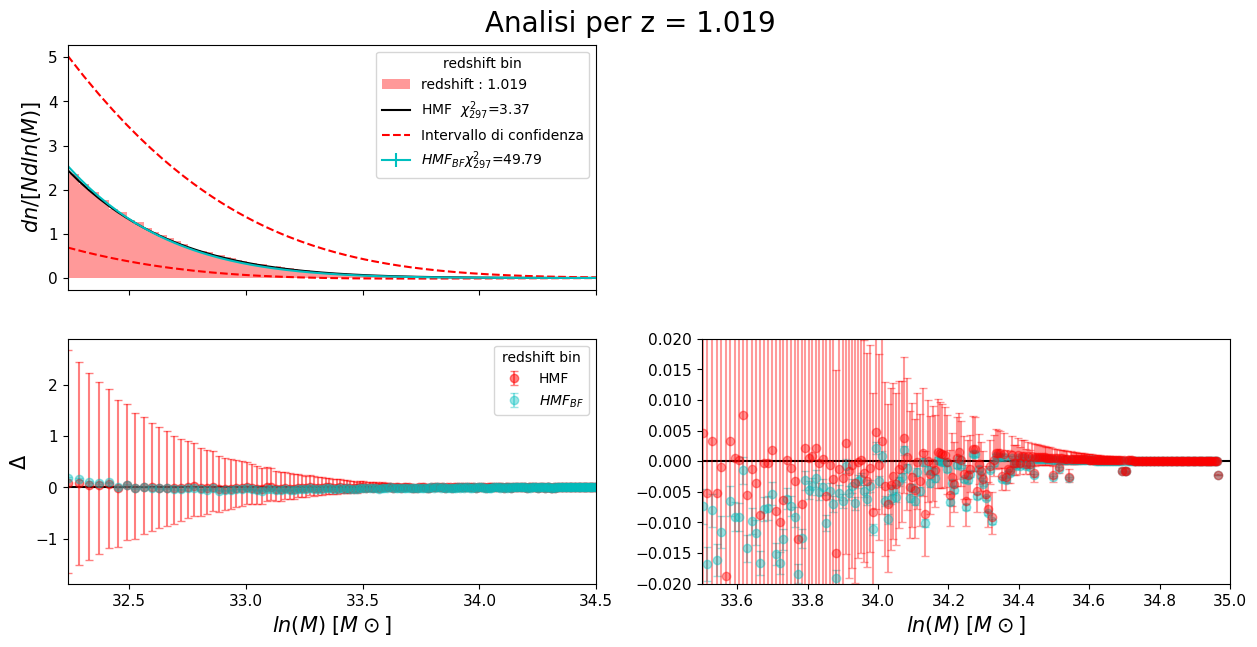

In [214]:
#Derivate per propagare l'errore sulla funzione teorica
der1 = d_funOm0(Om0_perc2[1],sigma8_perc2[1],xarr[1],z[1],vol[1],N[1])

der2 = d_funsigma8(Om0_perc2[1],sigma8_perc2[1],xarr[1],z[1],vol[1],N[1])

HMF_devSup2 = np.sqrt((der1*Om0sup2)**2+(der2*devsigma82)**2 +2*(der1*der2*devsigma82*Om0sup2*r2))
HMF_devInf2 = np.sqrt((der1*Om0inf2)**2+(der2*devsigma82)**2 +2*(der1*der2*devsigma82*Om0inf2*r2))

#Costruisco il plot
fig, ax = plt.subplots(2, 2,figsize=(15, 7),sharex = 'col' )
fig.suptitle('Analisi per z = {}'.format(z[1]),fontsize = 20,y=0.93)

#Funzioni principali
yerr = [HMF_devInf2,HMF_devSup2]
delta = model(Om0_perc2[1],sigma8_perc2[1],xarr[1],z[1],vol[1],N[1])-counts[1]

#Valori di best fit
Om0_perc2bf = bestf2[0]
sigma8_perc2bf = bestf2[1]

yerrbf = np.sqrt(model(Om0_perc2bf,sigma8_perc2bf,xarr[1],z[1],vol[1],N[1])*(1/(N[1]*dx[1])))  
deltabf = model(Om0_perc2bf,sigma8_perc2bf,xarr[1],z[1],vol[1],N[1])-counts[1]

#-----------------------------------------------------------------------

#Calcolo del chi quadro (già fatto precedentemente)
teo = model(Om0_perc2[1],sigma8_perc2[1],xarr[1],z[1],vol[1],N[1])
oss = counts[1]
chiq = chiquad(teo,oss,N[1],dx[1],np.maximum(HMF_devInf2,HMF_devSup2))
chi_rid = (chiq/(len(bins[1]-2)))     #Tengo conto della stima dei 2 parametri
#Chi quadro best fit


teobf = model(Om0_perc2bf,sigma8_perc2bf,xarr[1],z[1],vol[1],N[1])
chiqbf = chiquad(teobf,oss,N[1],dx[1],yerrbf)
chi_ridbf = (chiqbf/(len(bins[1]-2)))     #Tengo conto della stima dei 2 parametri

#-----------------------------------------------------------------------

ax[0,0].hist(np.log(mass[1]),density=True,bins=bins[1,:],label="redshift : {}".format(z[1]),color=color[1],alpha = 0.4) 
ax[0,0].plot(bins[1,:],model(Om0_perc2[1],sigma8_perc2[1],xarr[1],z[1],vol[1],N[1]),color='black',label='HMF  $\\chi_{{{}}}^2$={:.2f}'.format(len(bins[1])-2, chi_rid))
ax[0,0].errorbar(bins[1,:],model(Om0_perc2bf,sigma8_perc2bf,xarr[1],z[1],vol[1],N[1]),color='c' ,label='$HMF_{{BF}}\chi_{{{}}}^2$={:.2f}'.format(len(bins[1])-2, chi_ridbf),yerr=yerrbf)
#Intervallo di confidenza
ax[0,0].plot(bins[0,:],model(Om0_perc2[1],sigma8_perc2[1],xarr[1],z[1],vol[1],N[1]) + HMF_devSup2 ,color='red',linestyle="--",label='Intervallo di confidenza')
ax[0,0].plot(bins[0,:],model(Om0_perc2[1],sigma8_perc2[1],xarr[1],z[1],vol[1],N[1]) - HMF_devInf2,color='red',linestyle="--")

ax[0,0].set_ylabel("$dn/[Ndln(M)]}$", fontsize=15)
ax[0,0].legend(title = "redshift bin",prop={'size': 10})
ax[0,0].tick_params(axis='x', labelsize=11)
ax[0,0].tick_params(axis='y', labelsize=11)

#-----------------------------------------------------------------------

ax[0,1].axis('off')

#-----------------------------------------------------------------------

ax[1,0].axhline(0,color = 'black')
ax[1,0].errorbar(bins[1,:],delta,fmt='o',capsize=3,label='HMF',color = color[1],alpha = 0.5,yerr= yerr)
ax[1,0].errorbar(bins[1,:],deltabf,yerr = yerrbf,fmt='o',capsize=3,color='c',alpha=0.4,label='$HMF_{BF}$')

ax[1,0].set_ylabel("$\Delta$", fontsize=15)
ax[1,0].set_xlabel("$ln(M)$ [$M\odot$]", fontsize=15)
ax[1,0].legend(title = "redshift bin",prop={'size': 10})
ax[1,0].set_xlim([bins[1,0], 34.5])

#-----------------------------------------------------------------------

ax[1,1].axhline(0,color = 'black')
ax[1,1].errorbar(bins[1,:],deltabf,yerr = yerrbf,fmt='o',capsize=3,color='c' ,alpha=0.4)
ax[1,1].errorbar(bins[1,:],delta, fmt='o',capsize=3,color = color[1],alpha = 0.4,yerr= yerr)

ax[1,1].set_xlabel("$ln(M)$ [$M\odot$]", fontsize=15)
ax[1,1].set_ylim([-0.02, 0.02]) 
ax[1,1].set_xlim([33.5, 35])  

#-----------------------------------------------------------------------

i = 0
while i<2:
    ax[1,i].tick_params(axis='x', labelsize=11)
    ax[1,i].tick_params(axis='y', labelsize=11)
    i = i+1



$\Delta$ rappresenta la differenza tra valori teorici e valori misurati.

Nel primo grafico è riportato il confronto tra valori osservati (rosso), $HMF_{BF}$ teorica relativi ai parametri di best fit (azzurro) con errore pari $\sigma_{\rho_t}^2 = \frac{\rho_t}{Ndln(M)}$ e HMF teorica relativa ai parametri stimati dalla posterior (nero) con relativo intervallo di confidenza pari ad 1 deviazione standard (rosso tratteggiato).


Entrambi i modelli seguono l'andamento dei dati, ma osservando il grafico dei residui si notano delle discrepanze che, soprattuto nel caso di $HMF_{BF}$, portano a valori alti del $\chi^2$; che, a parità d'errore, risulta  maggiore rispetto a quello calcolato con i parametri iniziali ($\chi^2 \approx 31$).

Il modello descritto dai parametri stimati dalle posterior ($HMF$) presenta un intervallo di confidenza abbastanza ampio, ciò è dovuto all'incremento dell'incertezza sul parametro $Om0$.\
Sulla base di questo aumento dell'intervallo di confidenza sarebbe stato ragionevole trovare un valore $\chi^2<<1$, ma invece risulta $>1$; ciò potrebbe indicare che il modello studiato non è adatto allo studio della distribuzione in esame.

### 3.3 Stima parametri per z = 1.500


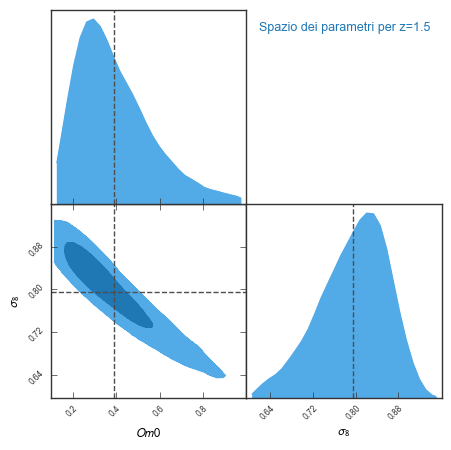

In [29]:
GTC = pygtc.plotGTC(chains=samples3,
                    paramNames=['$Om0$','$\sigma_8$'],
                    chainLabels=['Spazio dei parametri per z={}'.format(z[2])],
                    figureSize='MNRAS_page',
                    truths=[mean_Om0[2], mean_sigma8[2]])

Anche per questo redshift la correlazione tenderà a -1.\
Per quanto riguarda le distribuzioni marginalizzate si nota l'assimetria per entrambe le distribuzioni.

Parametro Om0
Valore mediano: 0.36
Errore superiore : 0.20
Errore inferiore : 0.13
----------------------
Parametro sigma8
Valore mediano: 0.80
Errore superiore : 0.05
Errore inferiore : 0.07
----------------------
Coefficiente di correlazione : -0.96
----------------------
Best fit
Om0 = 0.37
sigma8 = 0.78
----------------------


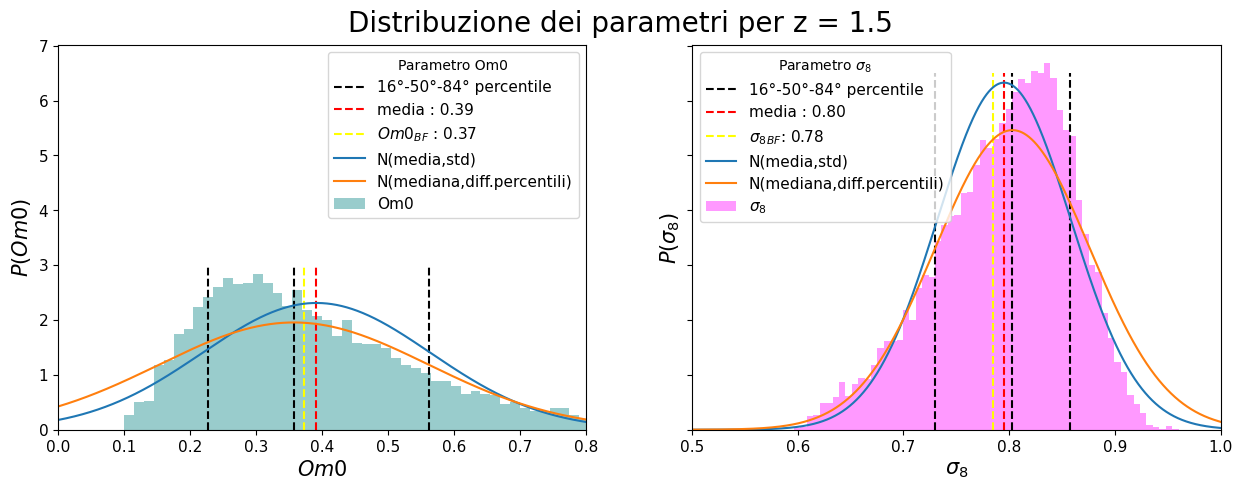

In [216]:
#Calcolo i percentili
Om0_perc3 = np.percentile(samples3[:, 0], [16, 50, 84])
sigma8_perc3 = np.percentile(samples3[:, 1], [16, 50, 84])

#-----------------------------------------------------------------------

#Costruisco il grafico
fig, ax  = plt.subplots(1, 2,figsize=(15, 5),sharey = True)
fig.suptitle('Distribuzione dei parametri per z = {}'.format(z[2]),fontsize = 20, y=0.95)


#Condizione if sui percentili per plottare la legenda solo una volta
i = 0
while i<3:
    if i == 0:
        ax[0].vlines(Om0_perc3[i],0,3, colors="black", linestyles="dashed", label='16°-50°-84° percentile')
        ax[1].vlines(sigma8_perc3[i],0,6.5, colors="black", linestyles="dashed",label='16°-50°-84° percentile')
    else:
        ax[1].vlines(sigma8_perc3[i],0,6.5, colors="black", linestyles="dashed")
        ax[0].vlines(Om0_perc3[i],0,3, colors="black", linestyles="dashed")
        
    i = i+1

#Plotto il valore medio calcolato dal samples precedentemente
ax[0].vlines(mean_Om0[2],0,3, colors="red", linestyles="dashed",label='media : {:.2f}'.format(mean_Om0[2]))
ax[1].vlines(mean_sigma8[2],0,6.5, colors="red", linestyles="dashed",label='media : {:.2f}'.format(mean_sigma8[2]))

#plot del valore di bestfit
ax[0].vlines(bestf3[0],0,3, colors="yellow", linestyles="dashed",label='${}_{{BF}}$ : {:.2f}'.format(string[0],bestf3[0]))
ax[1].vlines(bestf3[1],0,6.5, colors="yellow", linestyles="dashed",label='{}$_{{BF}}$: {:.2f}'.format(string[1],bestf3[1]))

#-----------------------------------------------------------------------

#Calcolo la deviazione prendendo il massimo valore tra la differenza dei due percentili (16,84) con il valore mediano
devOm03 = np.maximum((Om0_perc3[1]-Om0_perc3[0]),(Om0_perc3[2]-Om0_perc3[1]))
devsigma83 = np.maximum((sigma8_perc3[1]-sigma8_perc3[0]),(sigma8_perc3[2]-sigma8_perc3[1]))

#-----------------------------------------------------------------------

#Provo a fittare della gaussiane centrate nel valore medio o mediano
x = np.linspace(-1.0,1.0,len(samples3))
ax[1].plot(x,fun(x,mean_sigma8[2],deviazione_sigma8[2]),label='N(media,std)')
ax[1].plot(x,fun(x,sigma8_perc3[1],devsigma83),label='N(mediana,diff.percentili)')
ax[1].set_xlim([0.5, 1.])

ax[0].plot(x,fun(x,mean_Om0[2],deviazione_Om0[2]),label='N(media,std)')
ax[0].plot(x,fun(x,Om0_perc3[1],devOm03),label='N(mediana,diff.percentili)')
ax[0].set_xlim([0.0, 0.8])

#-----------------------------------------------------------------------

#Calcolo l'intervallo di confidenza per Om0 e sigma8
Om0inf3 = Om0_perc3[1]-Om0_perc3[0]
Om0sup3 = Om0_perc3[2]-Om0_perc3[1]

sigma8inf3 = sigma8_perc3[1]-sigma8_perc3[0]     
sigma8sup3 = sigma8_perc3[2]-sigma8_perc3[1]    

#-----------------------------------------------------------------------

i = 0
while i < 2:
    ax[i].hist(samples3[:,i], bins=60, density=True,color=color1[i],alpha=0.4,label = string[i])
    ax[0].set_xlabel("$Om0$", fontsize=15)
    ax[1].set_xlabel("$\sigma_{8}$", fontsize=15)
    ax[i].tick_params(axis='x', labelsize=11)
    ax[i].tick_params(axis='y', labelsize=11)
    ax[i].legend(title = "Parametro {}".format(string[i]),prop={'size': 11})
    i = i+1

ax[0].set_ylabel("$P(Om0)$", fontsize=15)
ax[1].set_ylabel("$P(\sigma_{8})$", fontsize=15)

#-----------------------------------------------------------------------

#Calcolo il coefficiente di Correlazione
r3 = np.corrcoef(samples3[:,0], samples3[:,1])[0, 1]

#-----------------------------------------------------------------------

print("Parametro Om0")
print("Valore mediano: {:.2f}".format(Om0_perc3[1]))
print("Errore superiore : {:.2f}".format(Om0sup3))
print("Errore inferiore : {:.2f}".format(Om0inf3))
print("----------------------")
print("Parametro sigma8")
print("Valore mediano: {:.2f}".format(sigma8_perc3[1]))
print("Errore superiore : {:.2f}".format(sigma8sup3))
print("Errore inferiore : {:.2f}".format(sigma8inf3))
print("----------------------")
print("Coefficiente di correlazione : {:.2f}".format(r3))
print("----------------------")
print("Best fit")
print("Om0 = {:.2f}".format(bestf3[0]))
print("sigma8 = {:.2f}".format(bestf3[1]))
print("----------------------")

Nel grafico sono riportate due gaussiane:
- $N(media,std)$ è stata realizzata utilizzando la media come valore centrale e la deviazione calcolata dal samples mediante numpy.std
- $N(mediana,diff.percentili)$ è stata calcolata utilizzando la mediana come valore centrale e deviazione pari al valore massimo tra la differenza dei percentili 16° e 84° con il 50° (nel caso di distribuzioni asimmetriche rappresenta una sovrastima dell'errore ma è più facile da trattare)



In questo caso entrambe le distribuzioni sono asimmetriche, conviene considerare il valore mediano con relativa incertezza per entrambe: 
$$ Om0_3 = 0.36 ^{0.20}_{0.13}$$ 
$$ \sigma_{8_3} = 0.80 ^{0.05}_{0.07} $$

Mentre il coefficiente di correlazione risulta essere:
$$r_3 = -0.96 $$
Il valore corrisponde ad una quasi perfetta correlazione lineare negativa ,come predetto dal grafico della distribuzione bidimensionale.


Il valore di best fit, calcolato minimizzando la posterior, risulta compatibile entro una deviazione con il valore mediano dei parametri.


Segue il confronto con i valori teorici di HMF con le distribuzioni osservate, analogamente ai casi precedenti.

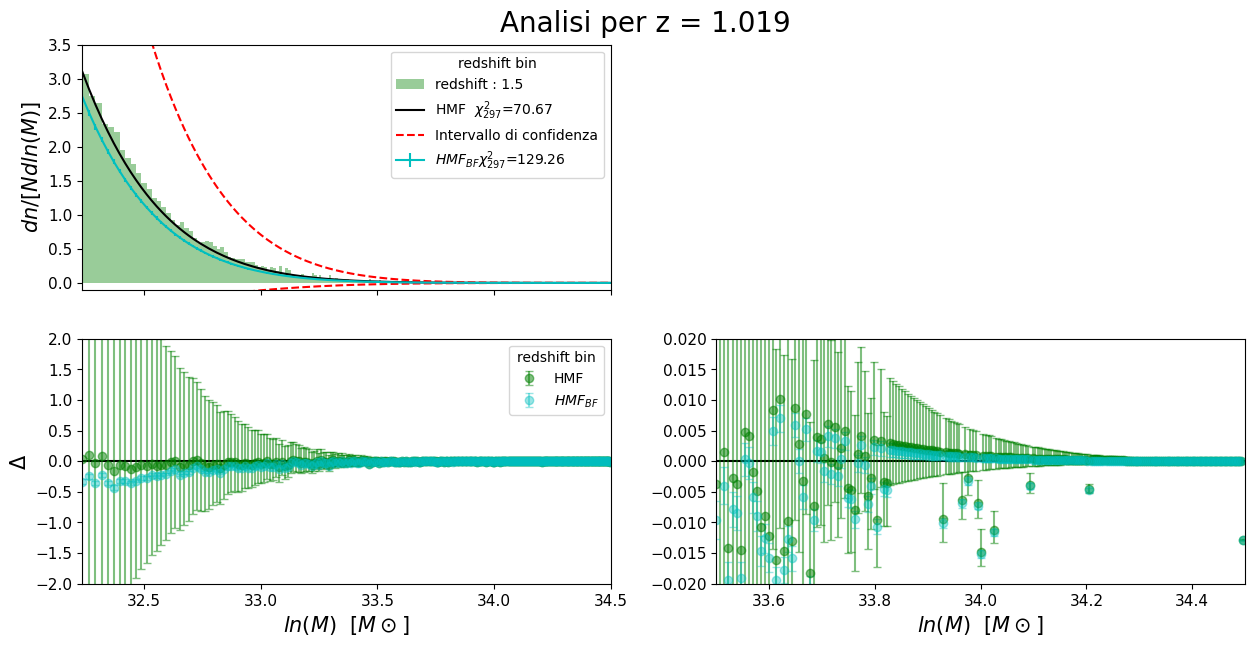

In [217]:
#Derivate per propagare l'errore sulla funzione teorica
der1 = d_funOm0(Om0_perc3[1],sigma8_perc3[1],xarr[2],z[2],vol[2],N[2])

der2 = d_funsigma8(Om0_perc3[1],sigma8_perc3[1],xarr[2],z[2],vol[2],N[2])

HMF_devSup3 = np.sqrt((der1*Om0sup3)**2+(der2*sigma8sup3)**2 +2*(der1*der2*sigma8sup3*Om0sup3*r3))
HMF_devInf3 = np.sqrt((der1*Om0inf3)**2+(der2*sigma8inf3)**2 +2*(der1*der2*sigma8inf3*Om0inf3*r3))

#-----------------------------------------------------------------------

#Costruisco il plot
fig, ax = plt.subplots(2, 2,figsize=(15, 7),sharex = 'col' )
fig.suptitle('Analisi per z = {}'.format(z[1]),fontsize = 20,y=0.93)

#Funzioni principali
yerr = [HMF_devInf3,HMF_devSup3]     #errore superiore e inferiore
delta = model(Om0_perc3[1],sigma8_perc3[1],xarr[2],z[2],vol[2],N[2])-counts[2]

#Valori di best fit
Om0_perc3bf = bestf3[0]
sigma8_perc3bf = bestf3[1]


yerrbf = np.sqrt(model(Om0_perc3bf,sigma8_perc3bf,xarr[2],z[2],vol[2],N[2])*(1/(N[2]*dx[2])))  
deltabf = model(Om0_perc3bf,sigma8_perc3bf,xarr[2],z[2],vol[2],N[2])-counts[2]

#-----------------------------------------------------------------------

#Calcolo del chi quadro (già fatto precedentemente)
teo = model(Om0_perc3[1],sigma8_perc3[1],xarr[2],z[2],vol[2],N[2])
oss = counts[2]
chiq = chiquad(teo,oss,N[2],dx[2],HMF_devSup3)
chi_rid = (chiq/(len(bins[2]-2)))     #Tengo conto della stima dei 2 parametri

teobf = model(Om0_perc3bf,sigma8_perc3bf,xarr[2],z[2],vol[2],N[2])
chiqbf = chiquad(teobf,oss,N[2],dx[2],yerrbf)
chi_ridbf = (chiqbf/(len(bins[2]-2)))     #Tengo conto della stima dei 2 parametri

#-----------------------------------------------------------------------

ax[0,0].hist(np.log(mass[2]),density=True,bins=bins[2,:],label="redshift : {}".format(z[2]),color=color[2],alpha = 0.4) 
ax[0,0].plot(bins[2,:],model(Om0_perc3[1],sigma8_perc3[1],xarr[2],z[2],vol[2],N[2]),color='black',label='HMF  $\\chi_{{{}}}^2$={:.2f}'.format(len(bins[2])-2, chi_rid))
ax[0,0].errorbar(bins[2,:],model(Om0_perc3bf,sigma8_perc3bf,xarr[2],z[2],vol[2],N[2]),color='c' ,label='$HMF_{{BF}}\chi_{{{}}}^2$={:.2f}'.format(len(bins[2])-2, chi_ridbf),yerr=yerrbf)
#Intervallo di confidenza
ax[0,0].plot(bins[2,:],model(Om0_perc3[1],sigma8_perc3[1],xarr[2],z[2],vol[2],N[2]) + HMF_devSup3 ,color='red',linestyle="--",label='Intervallo di confidenza')
ax[0,0].plot(bins[2,:],model(Om0_perc3[1],sigma8_perc3[1],xarr[2],z[2],vol[2],N[2]) - HMF_devInf3,color='red',linestyle="--")

ax[0,0].set_ylabel("$dn/[Ndln(M)]}$", fontsize=15)
ax[0,0].legend(title = "redshift bin",prop={'size': 10})
ax[0,0].tick_params(axis='x', labelsize=11)
ax[0,0].tick_params(axis='y', labelsize=11)
ax[0,0].set_ylim([-0.1, 3.5]) 

#-----------------------------------------------------------------------

ax[0,1].axis('off')

#-----------------------------------------------------------------------

ax[1,0].axhline(0,color = 'black')
ax[1,0].errorbar(bins[2,:],delta,fmt='o',capsize=3,label='HMF',color = color[2],alpha = 0.5,yerr= yerr)
ax[1,0].errorbar(bins[2,:],deltabf,yerr = yerrbf,fmt='o',capsize=3,color='c',alpha=0.4,label='$HMF_{BF}$')

ax[1,0].set_ylabel("$\Delta$", fontsize=15)
ax[1,0].set_xlabel("$ln(M)$  [$M\odot$]", fontsize=15)
ax[1,0].legend(title = "redshift bin",prop={'size': 10})
ax[1,0].set_xlim([bins[2,0], 34.5])
ax[1,0].set_ylim([-2,2]) 

#-----------------------------------------------------------------------

ax[1,1].axhline(0,color = 'black')
ax[1,1].errorbar(bins[2,:],delta, fmt='o',capsize=3,label ='{:.3f}'.format(z[2]),color = color[2],alpha = 0.5,yerr= yerr)
ax[1,1].errorbar(bins[2,:],deltabf,yerr = yerrbf,fmt='o',capsize=3,color='c' ,alpha=0.4,label='$HMF_{BF}$')

ax[1,1].set_xlabel("$ln(M)$  [$M\odot$]", fontsize=15)
ax[1,1].set_ylim([-0.02, 0.02]) 
ax[1,1].set_xlim([33.5, 34.5])  

#-----------------------------------------------------------------------

i = 0
while i<2:
    ax[1,i].tick_params(axis='x', labelsize=11)
    ax[1,i].tick_params(axis='y', labelsize=11)
    i = i+1



$\Delta$ rappresenta la differenza tra valori teorici e valori misurati.

Nel primo grafico è riportato il confronto tra valori osservati (verde), $HMF_{BF}$ teorica relativi ai parametri di best fit (azzurro) con errore pari $\sigma_{\rho_t}^2 = \frac{\rho_t}{Ndln(M)}$ e HMF teorica relativa ai parametri stimati dalla posterior (nero) con relativo intervallo di confidenza pari ad 1 deviazione standard (rosso tratteggiato).


Per quanto riguarda $HMF_{BF}$ si nota che sottostima la distribuzione osservata, soprattuto per i primi valori di massa, come si vede dal grafico dei residui; ciò è confermato dal valore del $\chi^2$ che risulta più grande rispetto a quello iniziale a parità d'errore ($\chi^2 \approx 52$).

L'andamento di $HMF$ sembra seguire correttamente l'andamento dei dati, anche se presenta un valore di $\chi^2>>1$.\
L'intervallo di confidenza per il modello HMF risulta molto ampio, ciò è ragionevole se si guarda l'istogramma delle distribuzioni dei parametri; queste infatti sono più asimmetriche rispetto alle precedenti e con un incertezza maggiore.\
Questo è indice del fatto che, all'aumentare del valore di redshift, la stima dei parametri e di conseguenza la previsione del modello peggiora.


### 3.4 Confronto


In [218]:
#Raccolgo le informazioni ricavate all'interno di vettori
corr = np.array([r1,r2,r3])   #coeff. di correlazione

mediana_Om0 = np.array([Om0_perc1[1],Om0_perc2[1],Om0_perc3[1]])  #valori mediani di Om0

mediana_sigma8 = np.array([sigma8_perc1[1],sigma8_perc2[1],sigma8_perc3[1]])    #valori mediani di sigma8 (i primi due coincidono con la media)

#Valori sovrastimati della deviazione (prenendo il massimo tra errore superiore ed inferiore)
dev_sigma8 = np.array([devsigma81,devsigma82,devsigma83])      #per sigma8 sono uguali alla deviazione della media (tranne l'ultimo valore)
dev_Om0 = np.array([devOm01,devOm02,devOm03])

#errori superiori ed inferiori
errOm0 = np.array([[Om0inf1, Om0sup1],[Om0inf2, Om0sup2],[Om0inf3, Om0sup3]])
errsigma8 = np.array([[devsigma81, devsigma81],[devsigma82, devsigma82],[sigma8inf3, sigma8sup3]])

print("Parametro {}".format(string[0]))
i = 0
while i<3:
    print("Per z={}".format(z[i]))
    print("Miglior stima: {:.2f}".format(mediana_Om0[i]))
    print("Errore sup: {:.2f}; Errore inf: {:.2f}".format(errOm0[i,1],errOm0[i,0]))
    print("------------------------------------")
    i = i+1

print("------------------------------------")
print("------------------------------------")

print("Parametro {}".format(string[1]))
i = 0
while i<3:
    print("Per z={}".format(z[i]))
    print("Miglior stima: {:.2f}".format(mediana_sigma8[i]))
    print("Errore sup: {:.2f}; Errore inf: {:.2f}".format(errsigma8[i,1],errsigma8[i,0]))
    print("------------------------------------")
    i = i+1

Parametro Om0
Per z=0.506
Miglior stima: 0.31
Errore sup: 0.11; Errore inf: 0.08
------------------------------------
Per z=1.019
Miglior stima: 0.33
Errore sup: 0.16; Errore inf: 0.11
------------------------------------
Per z=1.5
Miglior stima: 0.36
Errore sup: 0.20; Errore inf: 0.13
------------------------------------
------------------------------------
------------------------------------
Parametro $\sigma_8$
Per z=0.506
Miglior stima: 0.82
Errore sup: 0.08; Errore inf: 0.08
------------------------------------
Per z=1.019
Miglior stima: 0.81
Errore sup: 0.08; Errore inf: 0.08
------------------------------------
Per z=1.5
Miglior stima: 0.80
Errore sup: 0.05; Errore inf: 0.07
------------------------------------


Di seguito sono stati riportate le migliori stime ottenute:
- z = 0.506 : $\quad Om0 = 0.31 ^{0.11}_{0.08}$ $\quad$ $\sigma_8 = 0.82^{0.08}_{0.08}$
- z = 1.019 : $\quad Om0 = 0.33 ^{0.16}_{0.11}$ $\quad$ $\sigma_8 = 0.81^{0.08}_{0.08}$
- z = 1.500 : $\quad Om0 = 0.36 ^{0.20}_{0.13}$ $\quad$ $\sigma_8 = 0.80^{0.05}_{0.07}$

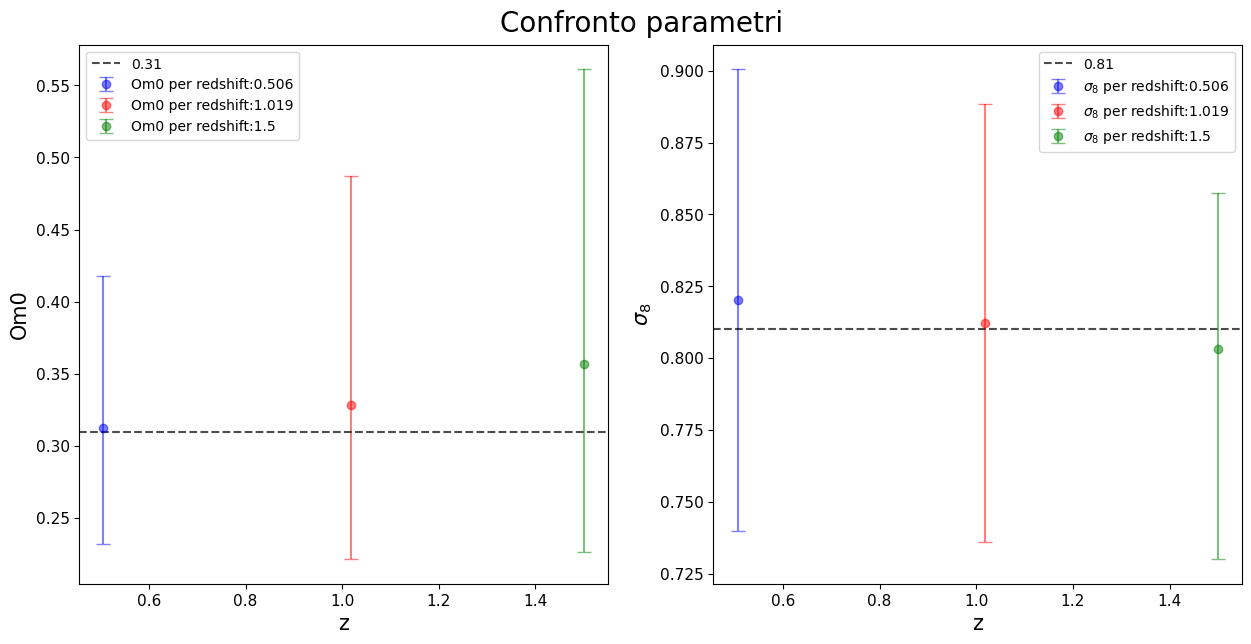

In [219]:
#Costruisco il plot dei parametri stimati
fig, ax = plt.subplots(1, 2,figsize=(15, 7))
fig.suptitle('Confronto parametri',fontsize = 20,y=0.93)

i = 0
while i < 3:
    yerr1 = [[errOm0[i, 0]], [errOm0[i, 1]]]  #errore inferiore e superiore
    yerr2 = [[errsigma8[i, 0]], [errsigma8[i, 1]]]  #errore inferiore e superiore
    
    ax[0].errorbar(z[i],mediana_Om0[i], yerr=yerr1, fmt='o', capsize=5,color = color[i],alpha=0.5,label='{} per redshift:{}'.format(string[0],z[i]))
    ax[1].errorbar(z[i],mediana_sigma8[i], yerr=yerr2, fmt='o', capsize=5,color = color[i],alpha=0.5,label='{} per redshift:{}'.format(string[1],z[i]))
    i =i+ 1


ax[0].axhline(0.31,0,z[2],color='black',label='0.31',linestyle="--", alpha = 0.7)
ax[1].axhline(0.81,0,z[2],color='black',label='0.81',linestyle="--", alpha = 0.7)


for i in range(2):
    ax[i].legend(prop={'size': 10})
    ax[i].tick_params(axis='y', labelsize=11)
    ax[i].tick_params(axis='x', labelsize=11)
    ax[i].set_xlabel("z", fontsize=15)
    ax[i].set_ylabel("{}".format(string[i]), fontsize=15)


Il seguente grafico mostra i diversi parametri ottenuti al varirare del valore di redshift, si osserva che per il parametro $Om0$ segue un'aumento del valore e dell'errore associato; mentre per $\sigma_8$ ne segue una diminuzione, come atteso dallo studio della correlazione.

I valori stimati risultano compatibili entro una deviazione con i valori utilizzati inizialmente, ovvero $Om0 = 0.31$ e $\sigma_8 = 0.81$.


Osservando i risultati ottenuti si evince che la HMF è molto sensibile alla variazione di parametri e redshift, infatti i modelli ottenuti per redshift z = 1.109 e z = 1.5 sono caratterizzati da valori di $\chi^2 >> 1$ e intervalli di confidenza molto ampi (a causa della crescente incertezza sui parametri). \
Per questo motivo combinare i risultati non porterebbe ad una maggiore bontà di adattamento del modello, per dimostrarlo segue il calcolo delle medie pesate per i due parametri con relativo confronto.

In [220]:
#Valore dei parametri ottenuto facendo la media pesata (prendo l'errore sovrastimato per facilità di calcolo)
Om0 = np.sum(mediana_Om0/dev_Om0**2)/(np.sum(1/dev_Om0**2))
std_Om0 = np.sqrt(1/np.sum(1/dev_Om0**2))

sigma8 = np.sum(mediana_sigma8/dev_sigma8**2)/(np.sum(1/dev_sigma8**2))
std_sigma8 = np.sqrt(1/np.sum(1/dev_sigma8**2))


------------------------
Parametro Om0
valore medio : 0.32, std 0.08
------------------------
------------------------
Parametro $\sigma_8$
valore medio : 0.81, std 0.04
------------------------


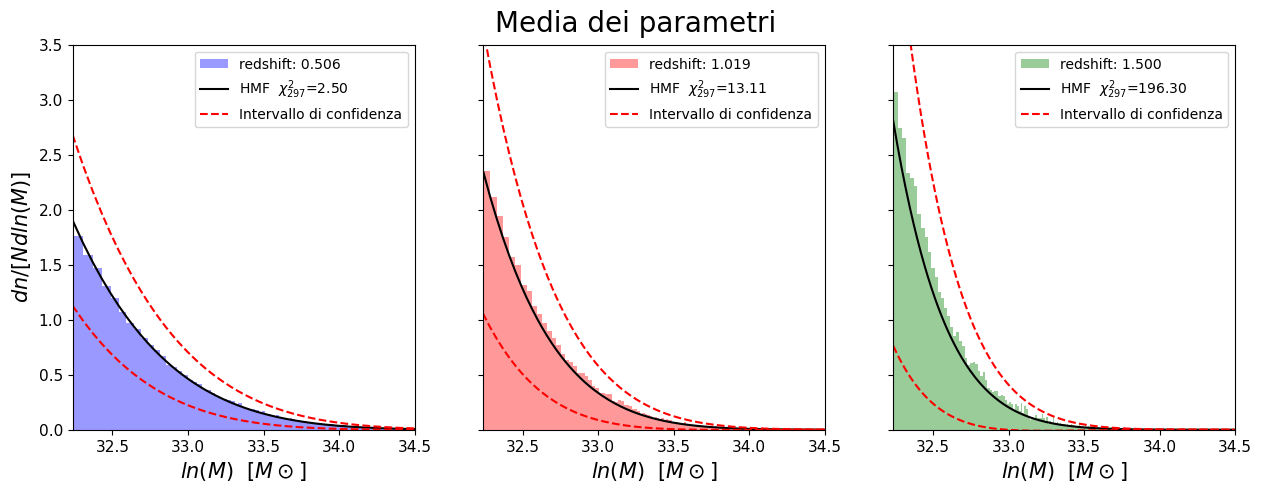

In [221]:
fig, ax  = plt.subplots(1, 3,figsize=(15, 5),sharey = True)
fig.suptitle('Media dei parametri',fontsize = 20, y=0.95)

i = 0
while i < 3:
    #Derivate per propagare l'errore sulla funzione teorica
    der1 = d_funOm0(Om0,sigma8,xarr[i],z[i],vol[i],N[i])    

    der2 = d_funsigma8(Om0,sigma8,xarr[i],z[i],vol[i],N[i])
    #Propagazione dell'errore    
    yerr = np.sqrt((der1*std_Om0)**2+(der2*std_sigma8)**2 +2*(der1*der2*std_sigma8*std_Om0*(-0.9)))
    
    teo = mfunc(xarr[i],z[i],vol[i],N[i])
    chiq = chiquad(teo,counts[i],N[i],dx[i],yerr)
    chi_rid = chiq/(len(bins[i])-2)     #divido per il numero di bins, in questo modo ottengo il valore ridotto del chi quadro (non ho parametri stimati)
    
    ax[i].hist(np.log(mass[i]),density=True,bins=bins[i],color=color[i],alpha=0.4,label=f'redshift: {z[i]:.3f}') 
    ax[i].plot(bins[i], model(Om0,sigma8,xarr[i],z[i],vol[i],N[i]),color='black',label = 'HMF  $\\chi_{{{}}}^2$={:.2f}'.format(len(bins[2])-2, chi_rid) )
    ax[i].plot(bins[i],yerr+ model(Om0,sigma8,xarr[i],z[i],vol[i],N[i]),color='red',linestyle="--",label = 'Intervallo di confidenza' )
    ax[i].plot(bins[i], model(Om0,sigma8,xarr[i],z[i],vol[i],N[i])-yerr,color='red',linestyle="--")

    ax[0].set_ylabel("$dn/[Ndln(M)]}$", fontsize=15)
    ax[i].set_xlabel("$ln(M)$  [$M\odot$]", fontsize=15)
    ax[i].tick_params(axis='x', labelsize=11)
    ax[i].tick_params(axis='y', labelsize=11)
    ax[i].set_xlim([bins[i,0], 34.5])
    ax[i].set_ylim([0,3.5])
    ax[i].legend(prop={'size': 10})

    i = i+1
    
print("------------------------")
print("Parametro {}".format(string[0]))
print("valore medio : {:.2f}, std {:.2f}".format(Om0,std_Om0))
print("------------------------")
print("------------------------")
print("Parametro {}".format(string[1]))
print("valore medio : {:.2f}, std {:.2f}".format(sigma8,std_sigma8))
print("------------------------")

Nel grafico è stata tracciata la HMF calcolata utilizzando i seguenti parametri (ottenuti unendo i precedenti):
$$Om0 = 0.32 \pm  0.08$$
$$\sigma_8 =  0.81 \pm 0.04$$
L'andamento sembra predire la distribuzione osservata in tutti i differenti bin di redshift, tuttavia i valori del $\chi^2$ indicano una scarsa bontà di addattamento; ben visibile nel secondo e terzo grafico.

Il modello teorico è adeguato in quanto segue l'andamento dei dati raccolti, ma li sottostima per valori di redshift come z = 1.109 e z = 1.5, è ragionevole scegliere come miglior stima dei parametri quelli relativi a z = 0.506.\
Il motivo è che il modello presenta un valore $\chi^2 \approx 1$ è un incertezza minore, indice di buon accordo tra teoria e misura.


## 4 Curvatura dell’Universo
Considerando una geometria dell'universo non necessariamente piatta è possibile determinare la densità di energia associata alla curvatura dell’Universo.\
Per studiare questo scenario è necessario variare il catalogo di parametri precedentemente utilizzato e considerare la densità di energia oscura Ode0.

Infatti vale 
$$\ohm_k = 1 - \ohm_m -\ohm_{\Lambda}$$
dove $\ohm_m = Om0$ e $\ohm_{\Lambda}=Ode0$.

Definendo la funzione logaritmica della posterior in modo analogo alla precedente analisi, cambia il numero di parametri (viene stimato solo $Om0$) e cambiano i parametri utilizzati (cambia la condizione $flat$ e $Ode0$). \
In particolare è noto che il valore $Ode0$ è approssimato da N(0.7, 0.05).\
Successivamente viene nuovamente implemenrato l'algoritmo EMCEE per studiare lo spazio del parametro Om0.

In [57]:
def log_prior(theta):    #Prior piatta per stimare Om0
    x = theta
    if(0.1<x<1.0):               
        return 0.0
    return -np.inf

def flat_model(theta,xarr,z,vol,N):
    x = theta
    params = {'flat': False, 'H0': 67.77, 'Ode0': 0.69, 'Om0': x, 'Ob0': 0.048254, 'sigma8': 0.81, 'ns': 0.96}   #flat = Flase
    cosmology.addCosmology('myCosmo', params)
    cosmo = cosmology.setCosmology('myCosmo')
    return ((mass_function.massFunction(xarr, z, mdef='vir',model='despali16', q_out='dndlnM')*vol)/N)


def log_likelihood(theta,xarr,z,vol,N,count):
    x = theta
    model_ = flat_model(theta,xarr,z,vol,N)
    likel = np.nansum(np.log((np.exp(-model_))*(model_**count)/(factorial(count, exact=False)))) 
    return likel

def log_posterior(theta,xarr,z,vol,N,count):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta,xarr,z,vol,N,count)



In [58]:
np.random.seed(42)

initial = np.array([0.3]) * (1 + 0.1*np.random.randn(1))  

pos = [0,0,0]

i = 0
while i<3:
    nll = 0
    nll = lambda *args: -log_posterior(*args)
    #seguono linee di controllo
    #print(i)
    #print("Log prior:", log_prior(initial))
    #print("Model output:", model(initial,xarr[i],z[i],vol[i],N[i]))
    #print("Log likelihood:", log_likelihood(initial,xarr[i],z[i],vol[i],N[i],counts[i]))
    #print("Log posterior:", log_posterior(initial,xarr[i],z[i],vol[i],N[i],counts[i]))
    soln = minimize(nll, initial, args=(xarr[i],z[i],vol[i],N[i],counts[i]))
    pos[i] = [soln.x]
    i = i+1
    
#Valori di BestFit
bestf = np.array(pos)
bestf1 = bestf[0].reshape(-1)
bestf2 = bestf[1].reshape(-1)
bestf3 = bestf[2].reshape(-1)

C:\Users\valer.PC1\anaconda3\envs\prova\lib\site-packages\scipy\optimize\_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
C:\Users\valer.PC1\anaconda3\envs\prova\lib\site-packages\scipy\optimize\_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
C:\Users\valer.PC1\anaconda3\envs\prova\lib\site-packages\scipy\optimize\_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0


In [182]:
#-----------Primo redshift--------
bestf1 = bestf[0].reshape(-1)

pos1 = bestf1*(1+ 1e-4*np.random.randn(30,1))    #32 walkers
nwalkers, ndim = pos1.shape

#commento il run_mcmc per permettere all'utente di fare "Run all cells"  (visto il costo computazionale)
sampler_flat1 = emcee.EnsembleSampler(nwalkers, ndim, log_posterior, args=(xarr,z[0],vol[0],N[0],counts[0]))
#sampler_flat1.run_mcmc(pos1, 1000, progress=True);


#Dato il costo computazionale salvo i file
np.save('chain_flat1.npy', sampler_flat1.get_chain())
np.save('chain_flat1_red.npy', sampler_flat1.get_chain(discard=100, flat=True))


100%|██████████| 1000/1000 [1:19:51<00:00,  4.79s/it]


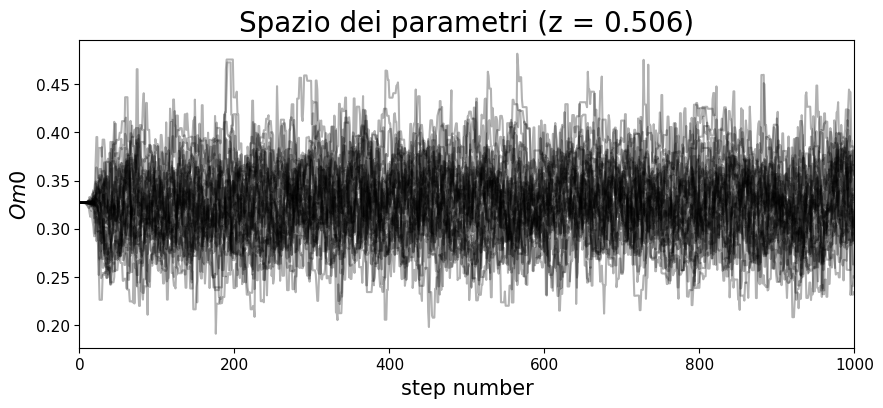

In [229]:
#samples_flat1 = sampler_flat1.get_chain()
samples_flat1 = np.load('chains/chain_flat1.npy')

plt.figure(figsize=(10, 4))
plt.title('Spazio dei parametri (z = {})'.format(z[0]),fontsize = 20,y=1)

plt.plot(samples_flat1[:, :, 0], "k", alpha=0.3)
    
plt.xlim(0, len(samples_flat1))
plt.ylabel("$Om0$",fontsize=15)
plt.tick_params(axis='x', labelsize=11)
plt.tick_params(axis='y', labelsize=11)
plt.xlabel("step number",fontsize=15);


samples_flat1 = np.load('chains/chain_flat1_red.npy')
#Calcolo il valore medio 
flat_Om01 = np.mean(samples_flat1)


In [18]:
#-----------Secondo redshift--------
bestf2 = bestf[1].reshape(-1)

pos2 = bestf2*(1+ 1e-4*np.random.randn(30,1))    #32 walkers
nwalkers, ndim = pos2.shape

#commento il run_mcmc per permettere all'utente di fare "Run all cells" (visto il costo computazionale)
sampler_flat2 = emcee.EnsembleSampler(nwalkers, ndim, log_posterior, args=(xarr,z[1],vol[1],N[1],counts[1]))
#sampler_flat2.run_mcmc(pos2, 1000, progress=True);

np.save('chain_flat2.npy', sampler_flat2.get_chain())
np.save('chain_flat2_red.npy', sampler_flat2.get_chain(discard=100, flat=True))


100%|██████████| 1000/1000 [1:38:50<00:00,  5.93s/it]


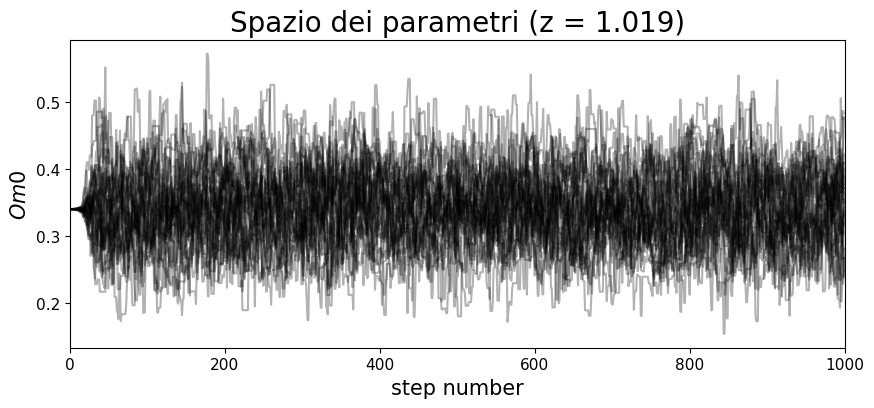

In [100]:
#samples_flat2 = sampler_flat2.get_chain()
samples_flat2 = np.load('chains/chain_flat2.npy')

plt.figure(figsize=(10, 4))
plt.title('Spazio dei parametri (z = {})'.format(z[1]),fontsize = 20,y=1)

plt.plot(samples_flat2[:, :, 0], "k", alpha=0.3)
    
plt.xlim(0, len(samples_flat2))
plt.ylabel("$Om0$",fontsize=15)
plt.tick_params(axis='x', labelsize=11)
plt.tick_params(axis='y', labelsize=11)
plt.xlabel("step number",fontsize=15);


samples_flat2 = np.load('chains/chain_flat2_red.npy')
flat_Om02 = np.mean(samples_flat2)

In [19]:
#-----------Terzo redshift--------
bestf3 = bestf[2].reshape(-1)

pos3 = bestf3*(1+ 1e-4*np.random.randn(30,1))    #32 walkers
nwalkers, ndim = pos3.shape

#commento il run_mcmc per permettere all'utente di fare "Run all cells" (visto il costo computazionale)
sampler_flat3 = emcee.EnsembleSampler(nwalkers, ndim, log_posterior, args=(xarr,z[2],vol[2],N[2],counts[2]))
#sampler_flat3.run_mcmc(pos3, 1000, progress=True);

np.save('chain_flat3.npy', sampler_flat3.get_chain())
np.save('chain_flat3_red.npy', sampler_flat3.get_chain(discard=100, flat=True))

100%|██████████| 1000/1000 [1:48:38<00:00,  6.52s/it]


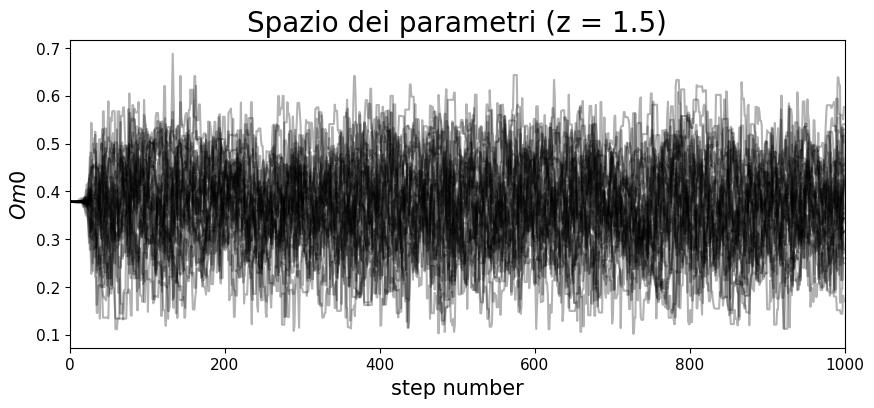

In [101]:
#samples_flat3 = sampler_flat3.get_chain()
samples_flat3 = np.load('chains/chain_flat3.npy')


plt.figure(figsize=(10, 4))
plt.title('Spazio dei parametri (z = {})'.format(z[2]),fontsize = 20,y=1)

plt.plot(samples_flat3[:, :, 0], "k", alpha=0.3)
    
plt.xlim(0, len(samples_flat3))
plt.ylabel("$Om0$",fontsize=15)
plt.tick_params(axis='x', labelsize=11)
plt.tick_params(axis='y', labelsize=11)
plt.xlabel("step number",fontsize=15);    


samples_flat3 = np.load('chains/chain_flat3_red.npy')
flat_Om03 = np.mean(samples_flat3)


### 4.1 Analisi dei parametri
Di seguito vengono istogrammati i valori ottenuti dallo studio della posterior.

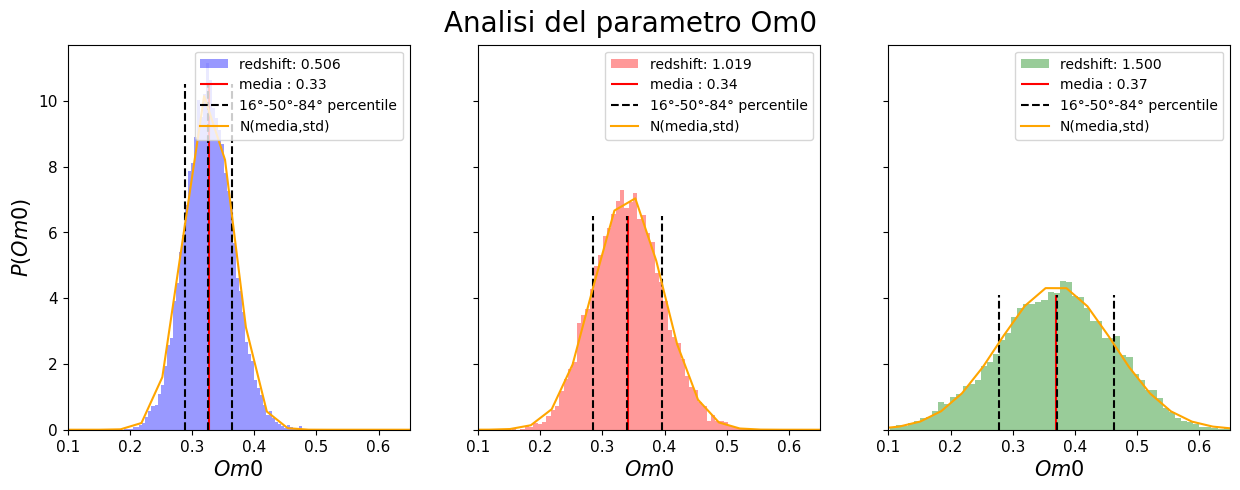

In [146]:
#raggruppo le catene e valori medi
samples_flat = [samples_flat1,samples_flat2,samples_flat3]

flat_Om0 = [flat_Om01,flat_Om02,flat_Om03]

flat_dev = [np.std(samples_flat1),np.std(samples_flat2),np.std(samples_flat3)]

altezz = [10.5,6.5,4.1]

#-------------------------------------------------------------------

#Costruisco il plot
fig, ax  = plt.subplots(1, 3,figsize=(15, 5),sharey = True)
fig.suptitle('Analisi del parametro Om0',fontsize = 20, y=0.95)

i = 0
j = 0
while i < 3:
    #Calcolo i percentili
    Om0_perc = np.percentile(samples_flat[i], [16, 50, 84])
    ax[i].hist(samples_flat[i],density=True,bins=60,color=color[i],alpha=0.4,label=f'redshift: {z[i]:.3f}') 

    #Plotto il valore medio ricavato dalle catene
    ax[i].vlines(flat_Om0[i],0,altezz[i], colors="red",label='media : {:.2f}'.format(flat_Om0[i]))
    
    #Plotto percentili e media in ogni grafico (condizione if per sistemare la legenda una sola volta)
    while j < 3:
        if j == 0:
            ax[i].vlines(Om0_perc[j], 0, altezz[i], colors="black", linestyles="dashed", label='16°-50°-84° percentile')
        else:
            ax[i].vlines(Om0_perc[j], 0, altezz[i], colors="black", linestyles="dashed")
        j = j+1
    j = 0
        
    
    ax[i].set_xlabel("$Om0$", fontsize=15)
    ax[i].tick_params(axis='x', 
                      labelsize=11)
    ax[i].tick_params(axis='y', labelsize=11)
    ax[i].set_xlim([0.10,0.65])
    i = i+1

ax[0].set_ylabel("$P(Om0)$", fontsize=15)
#-------------------------------------------------------------------

#Fitto le Gaussiane
x = np.linspace(-2,2,120)

i = 0
while i<3:
    ax[i].plot(x,fun(x,flat_Om0[i],flat_dev[i]),label='N(media,std)',color='orange')
    ax[i].legend(prop={'size': 10})

    i = i+1



Dai grafici si osserva che la distribuzione dei parametri in ogni bin di redshift è simmetrica e approssimabile ad una distribuzione Gaussiana.\
Per quanto riguarda la densità di energia oscura (Ode0) è possibile simulare la distribuzione Gaussiana N(0.7, 0.05) per poi determinare la distribuzione del parametro $\ohm_k$ studiando la convoluzione delle distribuzioni.

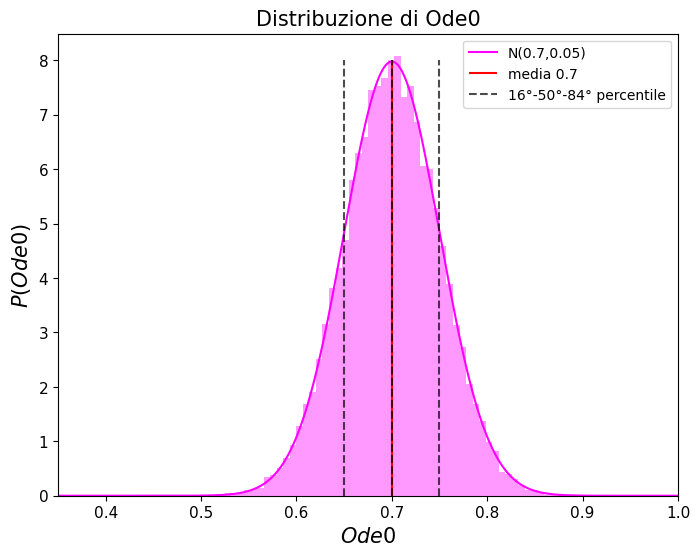

In [224]:
#Simulo i valori di Ode0 utilizzando numpy random normal (in alternativa avrei potuto utilizzare le trasformate di Box-Muller)
Ode0 = np.random.normal(loc=0.7, scale=0.05, size=len(samples_flat1))
Ode0_perc = np.percentile(Ode0, [16, 50, 84])

#-----------------------------------------------------

plt.figure(figsize=(8,6))
plt.title("Distribuzione di Ode0",fontsize = 15)
plt.hist(Ode0,bins=60,density=True,alpha=0.4,color='Magenta')
plt.plot(x,fun(x,0.7,0.05),color='magenta',label = 'N(0.7,0.05)')

#Plotto il valore medio e percetili
plt.vlines(0.7,0,8, colors="red",label = 'media {}'.format(0.7))

plt.vlines(Ode0_perc[0],0,8, colors="black",linestyles="dashed",label='16°-50°-84° percentile',alpha = 0.7)
plt.vlines(Ode0_perc[1],0,8, colors="black",linestyles="dashed",alpha = 0.7)
plt.vlines(Ode0_perc[2],0,8, colors="black",linestyles="dashed",alpha = 0.7)

plt.xlim([0.35,1])
plt.xlabel("$Ode0$", fontsize=15)
plt.ylabel("$P(Ode0)$", fontsize=15)

plt.tick_params(axis='x', labelsize=11)
plt.tick_params(axis='y', labelsize=11)
plt.legend(prop={'size': 10})
plt.show()

Di seguito viene ricavata la distribuzione di $\ohm_k = 1 - \ohm_m -\ohm_{\Lambda}$

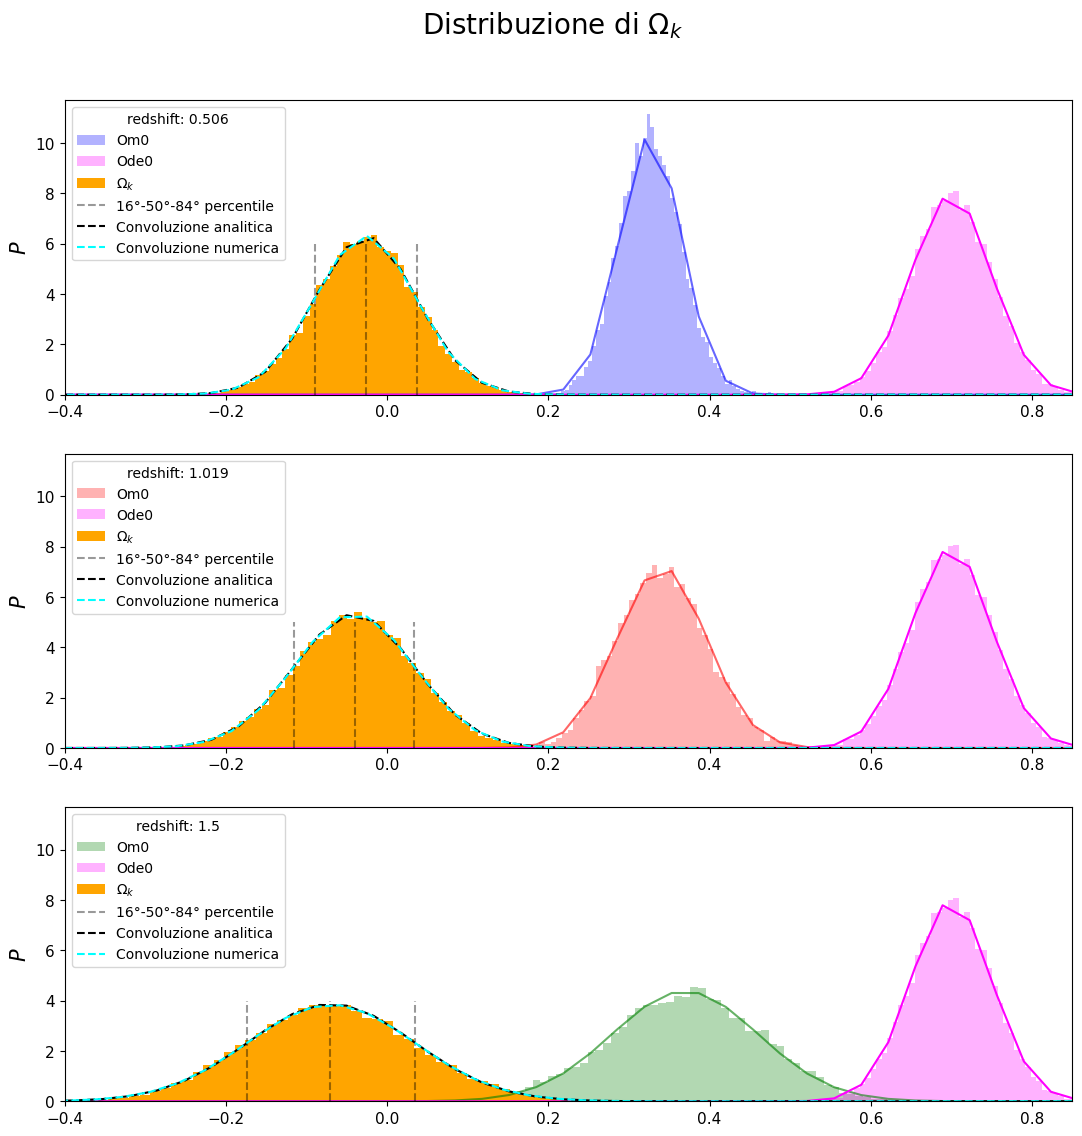

In [152]:
#Trasformo il vettore in un vettore colonna per renderlo compatibile con flat_samples
Ode0 = Ode0.reshape(-1, 1)

#-------------------------------------------------------------------

#Creo il plot
fig, ax  = plt.subplots(3, 1,figsize=(13, 13),sharey = True)
fig.suptitle("Distribuzione di $Ω_k$",fontsize = 20, y=0.95)

altezz = [6,5,4]

i = 0
j = 0
while i<3:
    ohmk = 1-samples_flat[i]-Ode0
    ohmk_perc =  np.percentile(ohmk, [16, 50, 84])
    mean_ohmk = np.mean(ohmk)
    std_ohmk = np.std(ohmk)

    ax[i].hist(samples_flat[i],bins=60,density=True,color=color[i],label="Om0",alpha=0.3)
    ax[i].hist(Ode0,bins=60,density=True,alpha=0.3,color='Magenta',label='Ode0')
    ax[i].hist(ohmk,bins=60,density=True,alpha=1,color='orange',label='$Ω_k$')
    ax[i].plot(x,fun(x,flat_Om0[i],flat_dev[i]),color=color[i],alpha=0.6)
    ax[i].plot(x,fun(x,0.7,0.05),color='Magenta')

    #Plotto percentili e media in ogni grafico (condizione if per sistemare la legenda una solaa volta)
    while j < 3:
        if j == 0:
            ax[i].vlines(ohmk_perc[j],0,altezz[i], colors="black", linestyles="dashed",alpha=0.4,label='16°-50°-84° percentile')
        else:
            ax[i].vlines(ohmk_perc[j],0,altezz[i], colors="black", linestyles="dashed",alpha=0.4)
        j = j+1
    j = 0
    
    ax[i].plot(x,fun(x,mean_ohmk,std_ohmk),color='black',label = 'Convoluzione analitica',linestyle="dashed")
        

#-------------------------------------------------------------------
    
    # Calcolo della convoluzione tramite integrazione
    convoluzione_valori = np.zeros_like(x)
    tau = x
    dx = tau[1]-tau[0]

    for k, t in enumerate(x):
        prodotto = fun(tau,flat_Om0[i],flat_dev[i]) * fun(t-tau,0.7,0.05)
        convoluzione_valori[k] = np.trapz(prodotto, dx=dx)   #Calcolo la somma delle distribuzioni

     #-1 nella coordinata x è necessario per trovare ohm_k = 1 - Om0 - Ode0  
    ax[i].plot(1-x,convoluzione_valori, label = 'Convoluzione numerica',color='cyan',linestyle="dashed")   

#-------------------------------------------------------------------
    ax[i].set_ylabel("$P$", fontsize=15)
   
    ax[i].tick_params(axis='x', labelsize=11)
    ax[i].tick_params(axis='y', labelsize=11)
    ax[i].set_xlim([-0.4,0.85])
    ax[i].legend(prop={'size': 10},title="redshift: {}".format(z[i]))
    i = i+1



La convoluzione numerica coincide con la convoluzione analitica come previsto, dunque è corretto dire che $\ohm_k$ è definito da una Gaussiana con i seguenti limiti:
- Per z = 0.506 : $\quad \ohm_k$=$-0.03 \quad$ $\sigma_{\ohm_k}$=$0.06$
- Per z = 1.109 : $\quad \ohm_k$=$-0.04 \quad$ $\sigma_{\ohm_k}$=$0.07$
- Per z = 1.500 : $\quad \ohm_k$=$-0.07 \quad$ $\sigma_{\ohm_k}$=$0.10$


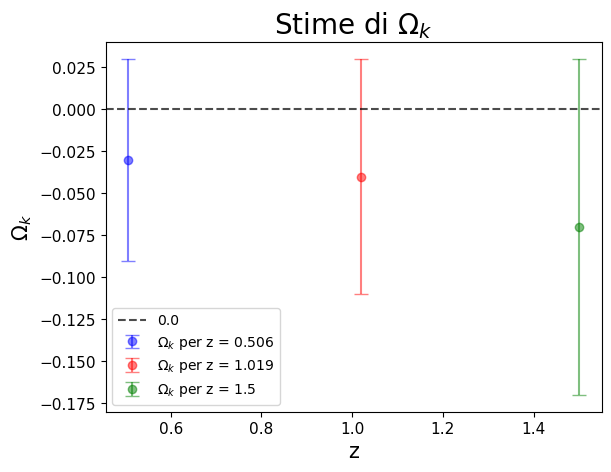

In [226]:
ohmk = [-0.03,-0.04,-0.07]
std = [0.06,0.07,0.1]

plt.title("Stime di $Ω_k$",fontsize = 20)
for i in range(3):
    plt.errorbar(z[i],ohmk[i],yerr = std[i], fmt='o', capsize=5,color = color[i],alpha=0.5,label = '$Ω_k$ per z = {}'.format(z[i]))

plt.xlabel("z",fontsize=15)
plt.ylabel("$Ω_k$",fontsize=15)
plt.tick_params(axis='x', labelsize=11)
plt.tick_params(axis='y', labelsize=11)
plt.axhline(0,0,z[2],color='black',label='0.0',linestyle="--", alpha = 0.7)


plt.legend()

Dal grafico si osserva che all'aumentare del redshift z, il valore di $\Omega_k$ tende a diminuire, mentre l'incertezza associata cresce; questo comportamento è ragionevole considerando che l'analisi precedente sul parametro $Om0$ ha mostrato un aumento sia del valore che dell'incertezza con l'incremento di z.

I risultati ottenuti non escludono l'ipotesi di un universo piatto $\ohm_k = 0$.

## 5 Conclusione

Il modello HMF studiato segue adeguatamente l'andamento delle distribuzioni di massa osservata per bin di redshift differenti, tuttavia presenta delle discrepanze all'aumentare del valore di redshift.\
Quindi, per quanto riguarda l'inferenza sui parametri, le stime migliori sono attribuite al bin di redshift inferiore (z = 0.506) in quanto il modello teorico mostra un ottimo accordo con le misure effettuate (come confermato dal $\chi^2$ ridotto).\
I valori ottenuti sono:
$$Om0 = 0.31^{0.11}_{0.08}$$ 

$$\sigma_8 = 0.82 ^{0.08}_{0.08}$$ 

$$\ohm_k = -0.03 ^{0.06}_{0.06}$$ 